In [3]:
!python -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.0 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [4]:
!pip install numpy

In [5]:
!pip install tqdm

In [6]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 144.4 MB/s eta 0:00:00


In [7]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 57.9 MB/s eta 0:00:00a 0:00:01


In [8]:
!pip install torch

Files already downloaded and verified

=== IID Sharding ===
Plot saved as: IID_Label_Distribution.pdf


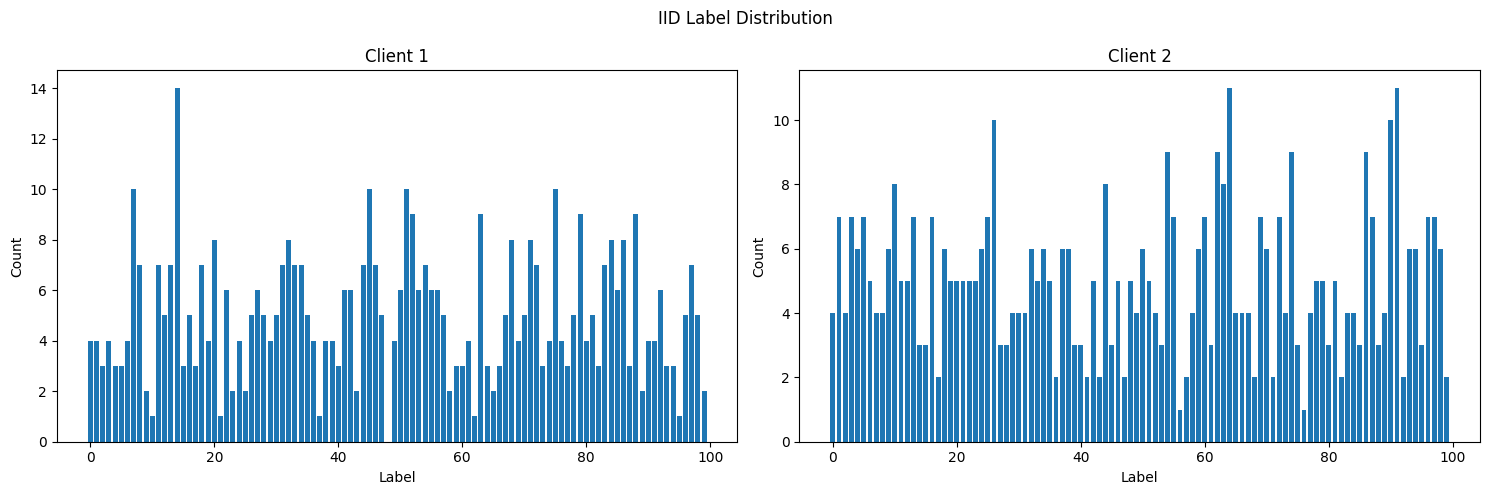

IID Sharding completed. Number of client: 100

=== Non-IID Sharding ===


Creating Non-IID Shards: 100%|██████████| 100/100 [00:00<00:00, 240086.09it/s]


Plot saved as: Non-IID_Label_Distribution.pdf


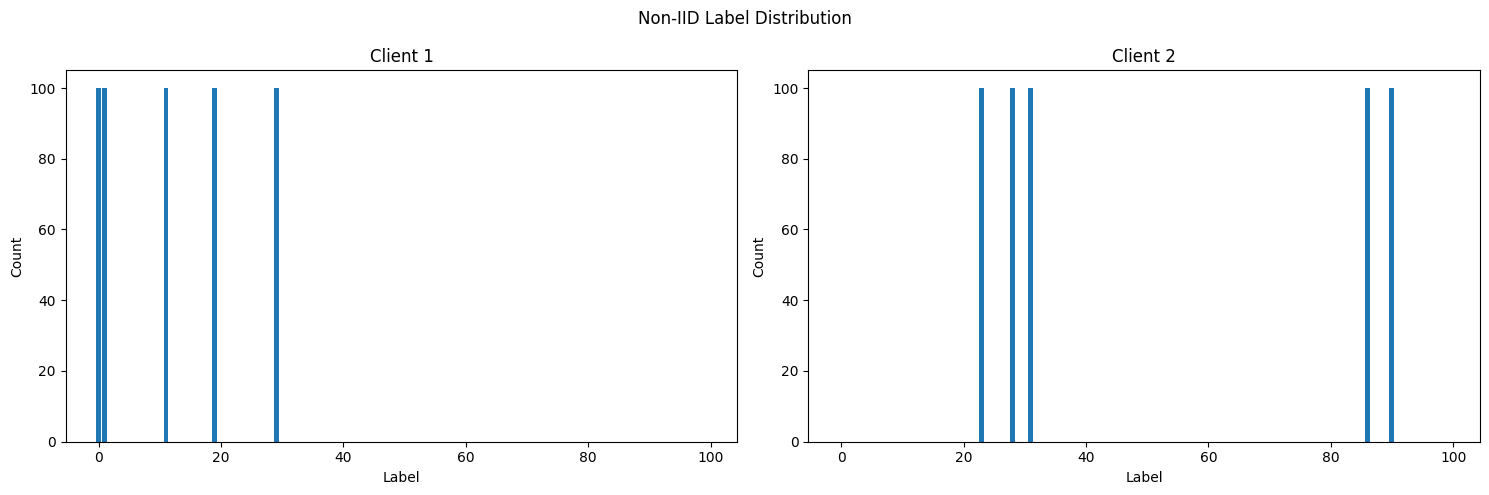

Non-IID Sharding completed. Number of client: 100


In [9]:
import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

class DatasetSharder:
    def __init__(self, config, trainset):
        self.num_clients = config.get('K')
        self.shard_type = config.get('shard_type')
        self.num_labels = config.get('Nc', None)
        self.dataset = trainset
        self._validate_configuration()

    def _validate_configuration(self):
        dataset_size = len(self.dataset)
        total_classes = len(set([label for _, label in self.dataset]))

        if self.num_clients > dataset_size:
            raise ValueError(f"Number of clients ({self.num_clients}) exceeds dataset size ({dataset_size}).")

        if self.shard_type == 'non_iid':
            if self.num_labels is None:
                raise ValueError("Number of labels per client ('Nc') must be specified for Non-IID sharding.")
            if self.num_labels > total_classes:
                raise ValueError(f"Number of labels per client ({self.num_labels}) "
                                 f"exceeds total number of classes ({total_classes}).")

    def create_iid_shards(self):
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.num_clients

        lengths = [samples_per_client] * self.num_clients
        remainder = dataset_size - samples_per_client * self.num_clients
        for i in range(remainder):
            lengths[i] += 1

        return random_split(self.dataset, lengths)

    def create_non_iid_shards(self):
        # Step 1: Group dataset indices by label
        label_to_indices = defaultdict(list)
        for idx, (_, label) in enumerate(self.dataset):
            label_to_indices[label].append(idx)

        # Step 2: Shuffle the indices for each label
        for label in label_to_indices:
            shuffle(label_to_indices[label])

        # Step 3: Initialize shards
        shards = [[] for _ in range(self.num_clients)]

        # Step 4: Calculate samples per client
        total_samples = len(self.dataset)
        samples_per_client = total_samples // self.num_clients

        # Step 5: Prepare list of all labels
        all_labels = list(label_to_indices.keys())

        # Create shards
        for client_id in tqdm(range(self.num_clients), desc="Creating Non-IID Shards"):
            start_label_idx = client_id * self.num_labels
            end_label_idx = (client_id + 1) * self.num_labels
            client_labels = all_labels[start_label_idx:end_label_idx]

            client_indices = []

            for label in client_labels:
                indices = label_to_indices[label]
                num_samples_per_label = samples_per_client // self.num_labels
                client_indices.extend(indices[:num_samples_per_label])
                label_to_indices[label] = indices[num_samples_per_label:]

            client_indices = client_indices[:samples_per_client]
            shards[client_id] = client_indices

        return [Subset(self.dataset, indices) for indices in shards]

    def shard_dataset(self):
        if self.shard_type == 'iid':
            return self.create_iid_shards()
        elif self.shard_type == 'non_iid':
            return self.create_non_iid_shards()
        else:
            raise ValueError(f"Unsupported shard_type: {self.shard_type}")

def load_cifar100():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
    ])

    trainset = datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    return trainset

def plot_label_distribution(client_datasets, num_classes=100, title="Label Distribution", max_clients_to_plot=2):
    num_clients_to_plot = min(len(client_datasets), max_clients_to_plot)

    client_labels = []
    for dataset in client_datasets[:num_clients_to_plot]:
        labels = [label for _, label in dataset]
        client_labels.append(labels)

    label_counts = []
    for labels in client_labels:
        counts = [labels.count(i) for i in range(num_classes)]
        label_counts.append(counts)

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(num_clients_to_plot):
        axes[i].bar(range(num_classes), label_counts[i])
        axes[i].set_title(f'Client {i+1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')

    plt.suptitle(title)
    plt.tight_layout()

    # Save the plots
    save_path = f"{title.replace(' ', '_')}.pdf"  # Save as PDF for LaTeX
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Plot saved as: {save_path}")

    plt.show()

def main():
    # Load the CIFAR-100 training dataset
    trainset = load_cifar100()

    # Create configurations for both Non-IID and IID
    configs = {
        'iid': {
            'K': 100,
            'shard_type': 'iid'
        },
        'non_iid': {
            'K': 100,
            'shard_type': 'non_iid',
            'Nc': 5
        }
    }

    # IID Sharding
    print("\n=== IID Sharding ===")
    iid_sharder = DatasetSharder(configs['iid'], trainset)
    iid_client_datasets = iid_sharder.shard_dataset()
    plot_label_distribution(iid_client_datasets, title="IID Label Distribution")
    print(f"IID Sharding completed. Number of client: {len(iid_client_datasets)}\n")

    # Non-IID Sharding
    print("=== Non-IID Sharding ===")
    non_iid_sharder = DatasetSharder(configs['non_iid'], trainset)
    non_iid_client_datasets = non_iid_sharder.shard_dataset()
    plot_label_distribution(non_iid_client_datasets, title="Non-IID Label Distribution")
    print(f"Non-IID Sharding completed. Number of client: {len(non_iid_client_datasets)}")

if __name__ == "__main__":
    main()

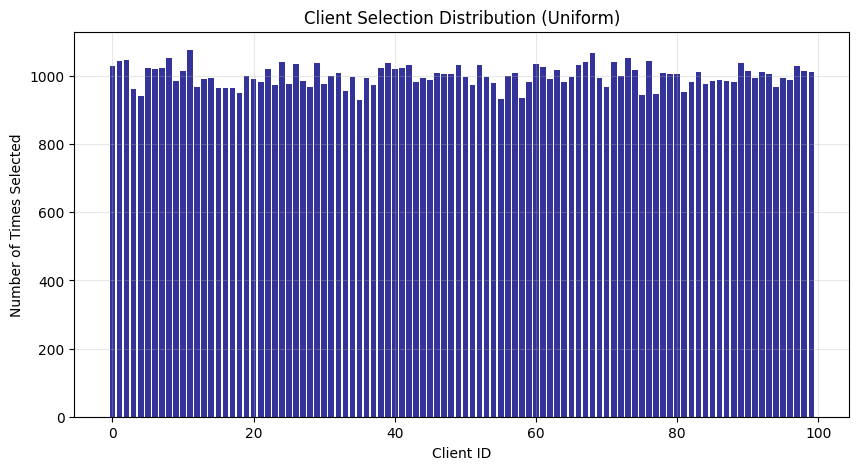

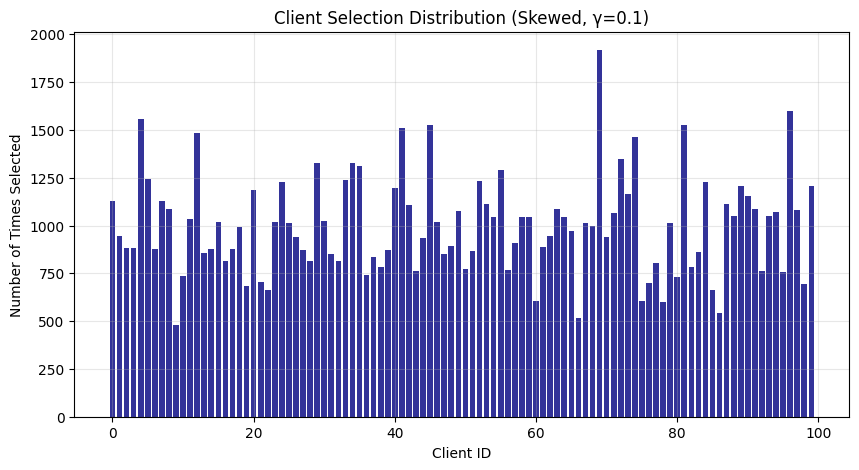

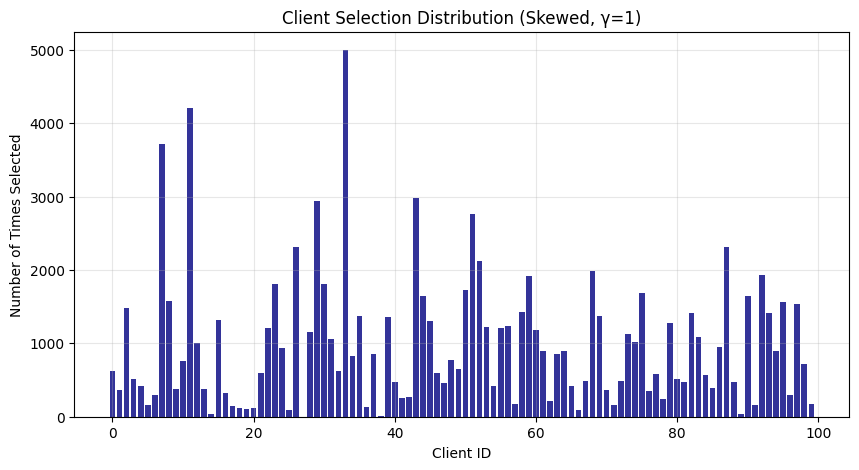

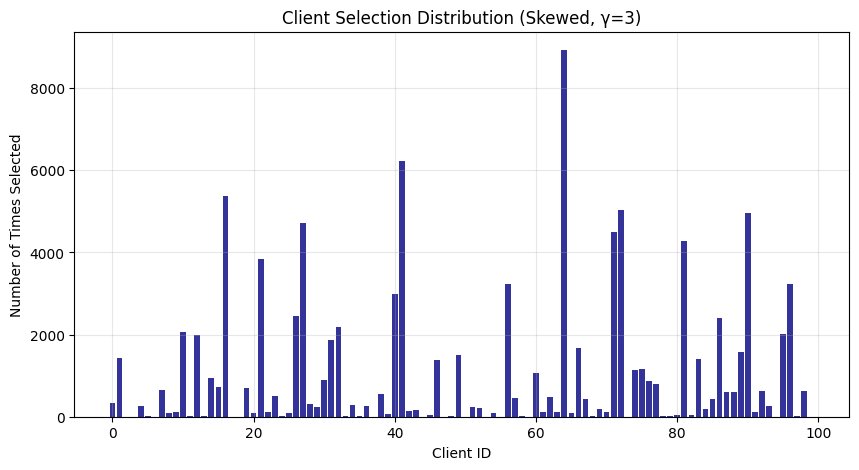

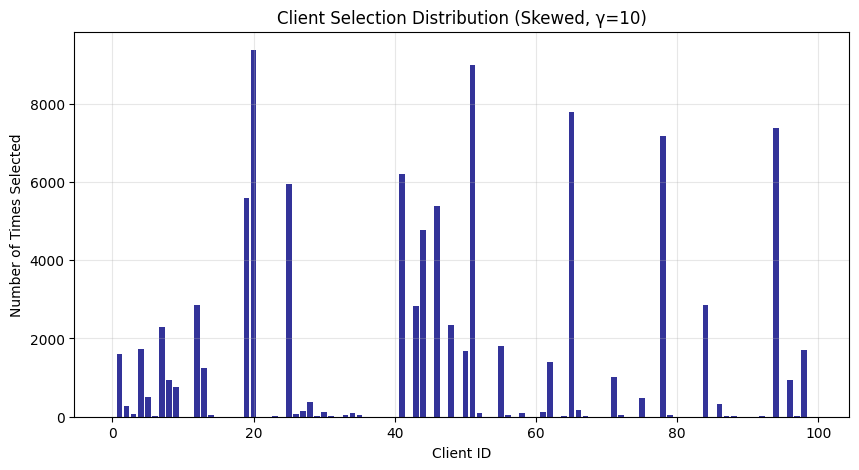

In [10]:
import numpy as np
import matplotlib.pyplot as plt

class ClientSelector:
    def __init__(self, config):
        self.num_clients = config['K']
        self.sample_size = int(max(config['C'] * self.num_clients, 1))
        self.client_indices = np.arange(self.num_clients)

        if config['participation'] == 'uniform':
            self.probabilities = None
        else:
            self.probabilities = np.random.dirichlet(
                alpha=np.full(self.num_clients, 1/config['gamma'])
            )

    def select(self):
        return np.random.choice(
            self.client_indices,
            size=self.sample_size,
            p=self.probabilities,
            replace=False
        )

def plot_client_participation(selector, num_rounds=10000, title=""):
    """Plot simple client participation distribution."""
    # Collect selections
    selections = []
    for _ in range(num_rounds):
        selections.append(selector.select())
    selections = np.array(selections).flatten()

    # Count selections per client
    clients, counts = np.unique(selections, return_counts=True)
    participation = np.zeros(selector.num_clients)
    for client, count in zip(clients, counts):
        participation[client] = count

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(selector.num_clients), participation,color = 'navy' , alpha=0.8)
    plt.xlabel('Client ID')
    plt.ylabel('Number of Times Selected')
    plt.title(f'Client Selection Distribution {title}')
    plt.grid(True, alpha=0.3)
    plt.show()


# Example usage
if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility

    # Uniform participation
    config_uniform = {
        'K': 100,
        'C': 0.1,
        'participation': 'uniform'
    }
    selector_uniform = ClientSelector(config_uniform)
    plot_client_participation(selector_uniform, title="(Uniform)")
# Skewed participation with different gamma values
if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility

    gamma_values = [0.1, 1, 3, 10]
    for gamma in gamma_values:
        config_skewed = {
            'K': 100,
            'C': 0.1,
            'participation': 'skewed',
            'gamma': gamma
        }
        selector_skewed = ClientSelector(config_skewed)
        plot_client_participation(selector_skewed, title=f"(Skewed, γ={gamma})")

Using device: cuda
Loading CIFAR-100 dataset...
Files already downloaded and verified
Files already downloaded and verified
Starting experiments at 2025-01-21 00:26:47

Running Uniform Participation...


Training:   0%|          | 1/1000 [00:06<1:47:13,  6.44s/it]


Round 1: Accuracy = 2.85%, Loss = 4.5886


Training:   1%|          | 10/1000 [00:53<1:30:27,  5.48s/it]


Round 10: Accuracy = 10.33%, Loss = 3.8596


Training:   2%|▏         | 20/1000 [01:45<1:28:38,  5.43s/it]


Round 20: Accuracy = 15.51%, Loss = 3.5288


Training:   3%|▎         | 30/1000 [02:37<1:26:14,  5.33s/it]


Round 30: Accuracy = 19.10%, Loss = 3.3211


Training:   4%|▍         | 40/1000 [03:28<1:25:45,  5.36s/it]


Round 40: Accuracy = 22.91%, Loss = 3.1342


Training:   5%|▌         | 50/1000 [04:20<1:25:44,  5.42s/it]


Round 50: Accuracy = 25.57%, Loss = 2.9710


Training:   6%|▌         | 60/1000 [05:12<1:24:32,  5.40s/it]


Round 60: Accuracy = 27.76%, Loss = 2.8397


Training:   7%|▋         | 70/1000 [06:04<1:24:25,  5.45s/it]


Round 70: Accuracy = 29.61%, Loss = 2.7378


Training:   8%|▊         | 80/1000 [06:56<1:23:17,  5.43s/it]


Round 80: Accuracy = 31.73%, Loss = 2.6243


Training:   9%|▉         | 90/1000 [07:49<1:24:40,  5.58s/it]


Round 90: Accuracy = 33.14%, Loss = 2.5621


Training:  10%|█         | 100/1000 [08:41<1:20:22,  5.36s/it]


Round 100: Accuracy = 34.89%, Loss = 2.4800


Training:  11%|█         | 110/1000 [09:33<1:20:36,  5.43s/it]


Round 110: Accuracy = 36.23%, Loss = 2.4343


Training:  12%|█▏        | 120/1000 [10:25<1:19:24,  5.41s/it]


Round 120: Accuracy = 36.95%, Loss = 2.3826


Training:  13%|█▎        | 130/1000 [11:18<1:20:13,  5.53s/it]


Round 130: Accuracy = 38.30%, Loss = 2.3229


Training:  14%|█▍        | 140/1000 [12:12<1:20:07,  5.59s/it]


Round 140: Accuracy = 38.71%, Loss = 2.2962


Training:  15%|█▌        | 150/1000 [13:04<1:16:35,  5.41s/it]


Round 150: Accuracy = 39.18%, Loss = 2.2583


Training:  16%|█▌        | 160/1000 [13:58<1:17:48,  5.56s/it]


Round 160: Accuracy = 40.09%, Loss = 2.2231


Training:  17%|█▋        | 170/1000 [14:49<1:14:27,  5.38s/it]


Round 170: Accuracy = 41.33%, Loss = 2.1969


Training:  18%|█▊        | 180/1000 [15:42<1:14:13,  5.43s/it]


Round 180: Accuracy = 41.23%, Loss = 2.1841


Training:  19%|█▉        | 190/1000 [16:35<1:14:43,  5.54s/it]


Round 190: Accuracy = 42.60%, Loss = 2.1381


Training:  20%|██        | 200/1000 [17:28<1:13:17,  5.50s/it]


Round 200: Accuracy = 42.74%, Loss = 2.1151


Training:  21%|██        | 210/1000 [18:20<1:12:47,  5.53s/it]


Round 210: Accuracy = 43.80%, Loss = 2.0882


Training:  22%|██▏       | 220/1000 [19:13<1:10:28,  5.42s/it]


Round 220: Accuracy = 44.10%, Loss = 2.0652


Training:  23%|██▎       | 230/1000 [20:05<1:09:03,  5.38s/it]


Round 230: Accuracy = 44.62%, Loss = 2.0578


Training:  24%|██▍       | 240/1000 [20:58<1:10:58,  5.60s/it]


Round 240: Accuracy = 45.42%, Loss = 2.0371


Training:  25%|██▌       | 250/1000 [21:51<1:07:46,  5.42s/it]


Round 250: Accuracy = 45.58%, Loss = 2.0053


Training:  26%|██▌       | 260/1000 [22:44<1:08:26,  5.55s/it]


Round 260: Accuracy = 46.09%, Loss = 1.9908


Training:  27%|██▋       | 270/1000 [23:36<1:05:58,  5.42s/it]


Round 270: Accuracy = 46.61%, Loss = 1.9818


Training:  28%|██▊       | 280/1000 [24:28<1:06:08,  5.51s/it]


Round 280: Accuracy = 46.65%, Loss = 1.9768


Training:  29%|██▉       | 290/1000 [25:20<1:04:10,  5.42s/it]


Round 290: Accuracy = 46.70%, Loss = 1.9614


Training:  30%|███       | 300/1000 [26:13<1:04:18,  5.51s/it]


Round 300: Accuracy = 46.99%, Loss = 1.9493


Training:  31%|███       | 310/1000 [27:05<1:01:59,  5.39s/it]


Round 310: Accuracy = 47.83%, Loss = 1.9230


Training:  32%|███▏      | 320/1000 [27:58<1:01:38,  5.44s/it]


Round 320: Accuracy = 47.71%, Loss = 1.9130


Training:  33%|███▎      | 330/1000 [28:50<1:00:17,  5.40s/it]


Round 330: Accuracy = 48.15%, Loss = 1.8883


Training:  34%|███▍      | 340/1000 [29:41<58:56,  5.36s/it]  


Round 340: Accuracy = 48.08%, Loss = 1.8850


Training:  35%|███▌      | 350/1000 [30:33<58:47,  5.43s/it]


Round 350: Accuracy = 48.92%, Loss = 1.8756


Training:  36%|███▌      | 360/1000 [31:25<58:19,  5.47s/it]


Round 360: Accuracy = 48.64%, Loss = 1.8784


Training:  37%|███▋      | 370/1000 [32:18<57:33,  5.48s/it]


Round 370: Accuracy = 49.27%, Loss = 1.8492


Training:  38%|███▊      | 380/1000 [33:11<56:17,  5.45s/it]


Round 380: Accuracy = 49.83%, Loss = 1.8471


Training:  39%|███▉      | 390/1000 [34:04<56:21,  5.54s/it]


Round 390: Accuracy = 49.64%, Loss = 1.8391


Training:  40%|████      | 400/1000 [34:56<54:19,  5.43s/it]


Round 400: Accuracy = 49.89%, Loss = 1.8376


Training:  41%|████      | 410/1000 [35:48<53:15,  5.42s/it]


Round 410: Accuracy = 49.61%, Loss = 1.8342


Training:  42%|████▏     | 420/1000 [36:40<52:33,  5.44s/it]


Round 420: Accuracy = 50.23%, Loss = 1.8166


Training:  43%|████▎     | 430/1000 [37:33<52:04,  5.48s/it]


Round 430: Accuracy = 50.85%, Loss = 1.8080


Training:  44%|████▍     | 440/1000 [38:25<50:11,  5.38s/it]


Round 440: Accuracy = 50.46%, Loss = 1.8134


Training:  45%|████▌     | 450/1000 [39:17<49:33,  5.41s/it]


Round 450: Accuracy = 51.04%, Loss = 1.7932


Training:  46%|████▌     | 460/1000 [40:09<48:32,  5.39s/it]


Round 460: Accuracy = 50.92%, Loss = 1.7934


Training:  47%|████▋     | 470/1000 [41:02<48:16,  5.46s/it]


Round 470: Accuracy = 50.97%, Loss = 1.7892


Training:  48%|████▊     | 480/1000 [41:54<47:04,  5.43s/it]


Round 480: Accuracy = 51.60%, Loss = 1.7724


Training:  49%|████▉     | 490/1000 [42:46<45:53,  5.40s/it]


Round 490: Accuracy = 52.00%, Loss = 1.7641


Training:  50%|█████     | 500/1000 [43:39<46:21,  5.56s/it]


Round 500: Accuracy = 52.32%, Loss = 1.7507


Training:  51%|█████     | 510/1000 [44:31<43:49,  5.37s/it]


Round 510: Accuracy = 52.27%, Loss = 1.7599


Training:  52%|█████▏    | 520/1000 [45:23<43:00,  5.38s/it]


Round 520: Accuracy = 51.52%, Loss = 1.7630


Training:  53%|█████▎    | 530/1000 [46:15<43:15,  5.52s/it]


Round 530: Accuracy = 52.18%, Loss = 1.7497


Training:  54%|█████▍    | 540/1000 [47:08<42:03,  5.49s/it]


Round 540: Accuracy = 51.67%, Loss = 1.7552


Training:  55%|█████▌    | 550/1000 [48:01<40:49,  5.44s/it]


Round 550: Accuracy = 51.82%, Loss = 1.7503


Training:  56%|█████▌    | 560/1000 [48:53<39:33,  5.39s/it]


Round 560: Accuracy = 52.35%, Loss = 1.7387


Training:  57%|█████▋    | 570/1000 [49:45<38:20,  5.35s/it]


Round 570: Accuracy = 52.57%, Loss = 1.7194


Training:  58%|█████▊    | 580/1000 [50:38<37:48,  5.40s/it]


Round 580: Accuracy = 52.28%, Loss = 1.7465


Training:  59%|█████▉    | 590/1000 [51:30<36:44,  5.38s/it]


Round 590: Accuracy = 52.59%, Loss = 1.7258


Training:  60%|██████    | 600/1000 [52:23<36:11,  5.43s/it]


Round 600: Accuracy = 53.08%, Loss = 1.7085


Training:  61%|██████    | 610/1000 [53:14<34:33,  5.32s/it]


Round 610: Accuracy = 53.46%, Loss = 1.7062


Training:  62%|██████▏   | 620/1000 [54:06<34:17,  5.41s/it]


Round 620: Accuracy = 53.06%, Loss = 1.7200


Training:  63%|██████▎   | 630/1000 [54:58<33:05,  5.37s/it]


Round 630: Accuracy = 53.28%, Loss = 1.7028


Training:  64%|██████▍   | 640/1000 [55:49<31:56,  5.32s/it]


Round 640: Accuracy = 53.81%, Loss = 1.6891


Training:  65%|██████▌   | 650/1000 [56:42<31:46,  5.45s/it]


Round 650: Accuracy = 54.19%, Loss = 1.6847


Training:  66%|██████▌   | 660/1000 [57:33<30:00,  5.30s/it]


Round 660: Accuracy = 53.49%, Loss = 1.6965


Training:  67%|██████▋   | 670/1000 [58:25<29:33,  5.37s/it]


Round 670: Accuracy = 53.87%, Loss = 1.6905


Training:  68%|██████▊   | 680/1000 [59:17<29:12,  5.48s/it]


Round 680: Accuracy = 53.60%, Loss = 1.6939


Training:  69%|██████▉   | 690/1000 [1:00:10<28:32,  5.52s/it]


Round 690: Accuracy = 54.01%, Loss = 1.6886


Training:  70%|███████   | 700/1000 [1:01:02<27:19,  5.47s/it]


Round 700: Accuracy = 54.18%, Loss = 1.6739


Training:  71%|███████   | 710/1000 [1:01:54<26:21,  5.45s/it]


Round 710: Accuracy = 54.19%, Loss = 1.6815


Training:  72%|███████▏  | 720/1000 [1:02:47<25:51,  5.54s/it]


Round 720: Accuracy = 53.78%, Loss = 1.6738


Training:  73%|███████▎  | 730/1000 [1:03:40<24:26,  5.43s/it]


Round 730: Accuracy = 54.00%, Loss = 1.6603


Training:  74%|███████▍  | 740/1000 [1:04:33<24:05,  5.56s/it]


Round 740: Accuracy = 54.48%, Loss = 1.6644


Training:  75%|███████▌  | 750/1000 [1:05:25<22:32,  5.41s/it]


Round 750: Accuracy = 53.90%, Loss = 1.6803


Training:  76%|███████▌  | 760/1000 [1:06:17<21:56,  5.49s/it]


Round 760: Accuracy = 54.55%, Loss = 1.6608


Training:  77%|███████▋  | 770/1000 [1:07:09<20:53,  5.45s/it]


Round 770: Accuracy = 54.27%, Loss = 1.6681


Training:  78%|███████▊  | 780/1000 [1:08:02<20:02,  5.46s/it]


Round 780: Accuracy = 54.57%, Loss = 1.6569


Training:  79%|███████▉  | 790/1000 [1:08:54<19:19,  5.52s/it]


Round 790: Accuracy = 55.12%, Loss = 1.6387


Training:  80%|████████  | 800/1000 [1:09:47<18:21,  5.51s/it]


Round 800: Accuracy = 55.09%, Loss = 1.6401


Training:  81%|████████  | 810/1000 [1:10:39<17:11,  5.43s/it]


Round 810: Accuracy = 55.58%, Loss = 1.6333


Training:  82%|████████▏ | 820/1000 [1:11:32<16:18,  5.44s/it]


Round 820: Accuracy = 54.64%, Loss = 1.6516


Training:  83%|████████▎ | 830/1000 [1:12:24<15:21,  5.42s/it]


Round 830: Accuracy = 54.85%, Loss = 1.6594


Training:  84%|████████▍ | 840/1000 [1:13:16<14:29,  5.43s/it]


Round 840: Accuracy = 54.98%, Loss = 1.6444


Training:  85%|████████▌ | 850/1000 [1:14:09<13:31,  5.41s/it]


Round 850: Accuracy = 55.22%, Loss = 1.6299


Training:  86%|████████▌ | 860/1000 [1:15:02<12:54,  5.53s/it]


Round 860: Accuracy = 55.03%, Loss = 1.6344


Training:  87%|████████▋ | 870/1000 [1:15:54<11:54,  5.50s/it]


Round 870: Accuracy = 55.04%, Loss = 1.6329


Training:  88%|████████▊ | 880/1000 [1:16:47<10:54,  5.45s/it]


Round 880: Accuracy = 55.40%, Loss = 1.6332


Training:  89%|████████▉ | 890/1000 [1:17:40<10:01,  5.47s/it]


Round 890: Accuracy = 55.61%, Loss = 1.6224


Training:  90%|█████████ | 900/1000 [1:18:32<09:07,  5.48s/it]


Round 900: Accuracy = 54.83%, Loss = 1.6351


Training:  91%|█████████ | 910/1000 [1:19:24<08:10,  5.45s/it]


Round 910: Accuracy = 54.82%, Loss = 1.6398


Training:  92%|█████████▏| 920/1000 [1:20:17<07:22,  5.53s/it]


Round 920: Accuracy = 55.40%, Loss = 1.6231


Training:  93%|█████████▎| 930/1000 [1:21:09<06:25,  5.51s/it]


Round 930: Accuracy = 55.26%, Loss = 1.6220


Training:  94%|█████████▍| 940/1000 [1:22:03<05:30,  5.50s/it]


Round 940: Accuracy = 55.60%, Loss = 1.6219


Training:  95%|█████████▌| 950/1000 [1:22:56<04:36,  5.53s/it]


Round 950: Accuracy = 55.84%, Loss = 1.6180


Training:  96%|█████████▌| 960/1000 [1:23:47<03:35,  5.38s/it]


Round 960: Accuracy = 55.87%, Loss = 1.6115


Training:  97%|█████████▋| 970/1000 [1:24:39<02:40,  5.35s/it]


Round 970: Accuracy = 56.03%, Loss = 1.6120


Training:  98%|█████████▊| 980/1000 [1:25:31<01:47,  5.38s/it]


Round 980: Accuracy = 55.90%, Loss = 1.6108


Training:  99%|█████████▉| 990/1000 [1:26:23<00:53,  5.37s/it]


Round 990: Accuracy = 55.17%, Loss = 1.6171


Training: 100%|██████████| 1000/1000 [1:27:15<00:00,  5.24s/it]



Round 1000: Accuracy = 56.21%, Loss = 1.5965

Running Skewed Participation (γ=0.1)...


Training:   0%|          | 1/1000 [00:06<1:44:11,  6.26s/it]


Round 1: Accuracy = 1.81%, Loss = 4.5960


Training:   1%|          | 10/1000 [00:53<1:31:18,  5.53s/it]


Round 10: Accuracy = 10.06%, Loss = 3.9065


Training:   2%|▏         | 20/1000 [01:45<1:26:53,  5.32s/it]


Round 20: Accuracy = 14.50%, Loss = 3.5914


Training:   3%|▎         | 30/1000 [02:37<1:28:43,  5.49s/it]


Round 30: Accuracy = 19.26%, Loss = 3.3160


Training:   4%|▍         | 40/1000 [03:30<1:26:51,  5.43s/it]


Round 40: Accuracy = 22.61%, Loss = 3.1368


Training:   5%|▌         | 50/1000 [04:22<1:26:28,  5.46s/it]


Round 50: Accuracy = 25.97%, Loss = 2.9686


Training:   6%|▌         | 60/1000 [05:14<1:24:31,  5.39s/it]


Round 60: Accuracy = 28.27%, Loss = 2.8399


Training:   7%|▋         | 70/1000 [06:07<1:26:16,  5.57s/it]


Round 70: Accuracy = 29.87%, Loss = 2.7470


Training:   8%|▊         | 80/1000 [07:00<1:23:33,  5.45s/it]


Round 80: Accuracy = 31.97%, Loss = 2.6472


Training:   9%|▉         | 90/1000 [07:53<1:22:10,  5.42s/it]


Round 90: Accuracy = 33.67%, Loss = 2.5691


Training:  10%|█         | 100/1000 [08:45<1:20:59,  5.40s/it]


Round 100: Accuracy = 34.94%, Loss = 2.5029


Training:  11%|█         | 110/1000 [09:37<1:21:11,  5.47s/it]


Round 110: Accuracy = 35.36%, Loss = 2.4659


Training:  12%|█▏        | 120/1000 [10:29<1:18:40,  5.36s/it]


Round 120: Accuracy = 37.36%, Loss = 2.3876


Training:  13%|█▎        | 130/1000 [11:22<1:18:01,  5.38s/it]


Round 130: Accuracy = 37.24%, Loss = 2.3727


Training:  14%|█▍        | 140/1000 [12:14<1:19:02,  5.51s/it]


Round 140: Accuracy = 38.01%, Loss = 2.3254


Training:  15%|█▌        | 150/1000 [13:07<1:16:59,  5.43s/it]


Round 150: Accuracy = 39.18%, Loss = 2.2851


Training:  16%|█▌        | 160/1000 [13:59<1:16:59,  5.50s/it]


Round 160: Accuracy = 39.98%, Loss = 2.2582


Training:  17%|█▋        | 170/1000 [14:53<1:17:11,  5.58s/it]


Round 170: Accuracy = 40.94%, Loss = 2.2220


Training:  18%|█▊        | 180/1000 [15:46<1:15:41,  5.54s/it]


Round 180: Accuracy = 41.04%, Loss = 2.2094


Training:  19%|█▉        | 190/1000 [16:39<1:15:58,  5.63s/it]


Round 190: Accuracy = 42.06%, Loss = 2.1605


Training:  20%|██        | 200/1000 [17:31<1:12:46,  5.46s/it]


Round 200: Accuracy = 42.38%, Loss = 2.1527


Training:  21%|██        | 210/1000 [18:24<1:11:49,  5.45s/it]


Round 210: Accuracy = 43.48%, Loss = 2.1097


Training:  22%|██▏       | 220/1000 [19:17<1:10:50,  5.45s/it]


Round 220: Accuracy = 43.71%, Loss = 2.1032


Training:  23%|██▎       | 230/1000 [20:08<1:08:52,  5.37s/it]


Round 230: Accuracy = 43.98%, Loss = 2.0914


Training:  24%|██▍       | 240/1000 [21:01<1:09:17,  5.47s/it]


Round 240: Accuracy = 44.31%, Loss = 2.0561


Training:  25%|██▌       | 250/1000 [21:54<1:07:42,  5.42s/it]


Round 250: Accuracy = 44.71%, Loss = 2.0434


Training:  26%|██▌       | 260/1000 [22:46<1:05:50,  5.34s/it]


Round 260: Accuracy = 45.12%, Loss = 2.0389


Training:  27%|██▋       | 270/1000 [23:39<1:06:17,  5.45s/it]


Round 270: Accuracy = 45.76%, Loss = 2.0188


Training:  28%|██▊       | 280/1000 [24:31<1:05:32,  5.46s/it]


Round 280: Accuracy = 46.15%, Loss = 1.9968


Training:  29%|██▉       | 290/1000 [25:22<1:03:13,  5.34s/it]


Round 290: Accuracy = 46.74%, Loss = 1.9765


Training:  30%|███       | 300/1000 [26:15<1:03:33,  5.45s/it]


Round 300: Accuracy = 46.68%, Loss = 1.9690


Training:  31%|███       | 310/1000 [27:07<1:02:35,  5.44s/it]


Round 310: Accuracy = 47.08%, Loss = 1.9533


Training:  32%|███▏      | 320/1000 [28:00<1:02:32,  5.52s/it]


Round 320: Accuracy = 47.35%, Loss = 1.9688


Training:  33%|███▎      | 330/1000 [28:52<1:00:48,  5.45s/it]


Round 330: Accuracy = 48.48%, Loss = 1.9196


Training:  34%|███▍      | 340/1000 [29:45<1:01:05,  5.55s/it]


Round 340: Accuracy = 47.57%, Loss = 1.9278


Training:  35%|███▌      | 350/1000 [30:37<58:33,  5.41s/it]  


Round 350: Accuracy = 48.19%, Loss = 1.9143


Training:  36%|███▌      | 360/1000 [31:30<59:05,  5.54s/it]


Round 360: Accuracy = 47.90%, Loss = 1.9193


Training:  37%|███▋      | 370/1000 [32:23<57:42,  5.50s/it]


Round 370: Accuracy = 48.51%, Loss = 1.9112


Training:  38%|███▊      | 380/1000 [33:16<57:21,  5.55s/it]


Round 380: Accuracy = 49.14%, Loss = 1.8662


Training:  39%|███▉      | 390/1000 [34:09<55:37,  5.47s/it]


Round 390: Accuracy = 49.53%, Loss = 1.8649


Training:  40%|████      | 400/1000 [35:01<54:28,  5.45s/it]


Round 400: Accuracy = 49.18%, Loss = 1.8498


Training:  41%|████      | 410/1000 [35:53<53:11,  5.41s/it]


Round 410: Accuracy = 49.29%, Loss = 1.8599


Training:  42%|████▏     | 420/1000 [36:46<52:41,  5.45s/it]


Round 420: Accuracy = 49.45%, Loss = 1.8508


Training:  43%|████▎     | 430/1000 [37:38<51:19,  5.40s/it]


Round 430: Accuracy = 49.93%, Loss = 1.8332


Training:  44%|████▍     | 440/1000 [38:31<50:54,  5.45s/it]


Round 440: Accuracy = 49.57%, Loss = 1.8271


Training:  45%|████▌     | 450/1000 [39:24<50:06,  5.47s/it]


Round 450: Accuracy = 51.00%, Loss = 1.8136


Training:  46%|████▌     | 460/1000 [40:16<49:54,  5.55s/it]


Round 460: Accuracy = 50.97%, Loss = 1.8212


Training:  47%|████▋     | 470/1000 [41:09<48:22,  5.48s/it]


Round 470: Accuracy = 50.65%, Loss = 1.8180


Training:  48%|████▊     | 480/1000 [42:01<46:22,  5.35s/it]


Round 480: Accuracy = 50.85%, Loss = 1.8000


Training:  49%|████▉     | 490/1000 [42:53<46:00,  5.41s/it]


Round 490: Accuracy = 51.24%, Loss = 1.7961


Training:  50%|█████     | 500/1000 [43:45<45:20,  5.44s/it]


Round 500: Accuracy = 50.98%, Loss = 1.8007


Training:  51%|█████     | 510/1000 [44:37<44:39,  5.47s/it]


Round 510: Accuracy = 51.57%, Loss = 1.7842


Training:  52%|█████▏    | 520/1000 [45:30<43:53,  5.49s/it]


Round 520: Accuracy = 51.25%, Loss = 1.7862


Training:  53%|█████▎    | 530/1000 [46:22<42:28,  5.42s/it]


Round 530: Accuracy = 51.57%, Loss = 1.7697


Training:  54%|█████▍    | 540/1000 [47:15<41:32,  5.42s/it]


Round 540: Accuracy = 51.50%, Loss = 1.7702


Training:  55%|█████▌    | 550/1000 [48:07<40:40,  5.42s/it]


Round 550: Accuracy = 51.63%, Loss = 1.7641


Training:  56%|█████▌    | 560/1000 [48:59<39:30,  5.39s/it]


Round 560: Accuracy = 51.68%, Loss = 1.7588


Training:  57%|█████▋    | 570/1000 [49:51<38:22,  5.35s/it]


Round 570: Accuracy = 51.99%, Loss = 1.7524


Training:  58%|█████▊    | 580/1000 [50:43<37:24,  5.35s/it]


Round 580: Accuracy = 52.61%, Loss = 1.7453


Training:  59%|█████▉    | 590/1000 [51:35<37:05,  5.43s/it]


Round 590: Accuracy = 52.46%, Loss = 1.7344


Training:  60%|██████    | 600/1000 [52:26<36:21,  5.45s/it]


Round 600: Accuracy = 52.43%, Loss = 1.7319


Training:  61%|██████    | 610/1000 [53:19<35:40,  5.49s/it]


Round 610: Accuracy = 52.44%, Loss = 1.7393


Training:  62%|██████▏   | 620/1000 [54:11<34:43,  5.48s/it]


Round 620: Accuracy = 52.85%, Loss = 1.7307


Training:  63%|██████▎   | 630/1000 [55:04<33:29,  5.43s/it]


Round 630: Accuracy = 52.78%, Loss = 1.7168


Training:  64%|██████▍   | 640/1000 [55:55<31:50,  5.31s/it]


Round 640: Accuracy = 53.13%, Loss = 1.7216


Training:  65%|██████▌   | 650/1000 [56:48<32:30,  5.57s/it]


Round 650: Accuracy = 53.03%, Loss = 1.7297


Training:  66%|██████▌   | 660/1000 [57:41<31:09,  5.50s/it]


Round 660: Accuracy = 53.04%, Loss = 1.7189


Training:  67%|██████▋   | 670/1000 [58:33<29:58,  5.45s/it]


Round 670: Accuracy = 52.58%, Loss = 1.7306


Training:  68%|██████▊   | 680/1000 [59:26<29:45,  5.58s/it]


Round 680: Accuracy = 53.04%, Loss = 1.7093


Training:  69%|██████▉   | 690/1000 [1:00:19<28:24,  5.50s/it]


Round 690: Accuracy = 53.29%, Loss = 1.7052


Training:  70%|███████   | 700/1000 [1:01:11<27:24,  5.48s/it]


Round 700: Accuracy = 53.46%, Loss = 1.6970


Training:  71%|███████   | 710/1000 [1:02:04<26:29,  5.48s/it]


Round 710: Accuracy = 53.53%, Loss = 1.7090


Training:  72%|███████▏  | 720/1000 [1:02:57<25:39,  5.50s/it]


Round 720: Accuracy = 53.73%, Loss = 1.6995


Training:  73%|███████▎  | 730/1000 [1:03:50<24:27,  5.44s/it]


Round 730: Accuracy = 53.74%, Loss = 1.6935


Training:  74%|███████▍  | 740/1000 [1:04:41<23:14,  5.36s/it]


Round 740: Accuracy = 54.05%, Loss = 1.6961


Training:  75%|███████▌  | 750/1000 [1:05:34<22:32,  5.41s/it]


Round 750: Accuracy = 53.49%, Loss = 1.6863


Training:  76%|███████▌  | 760/1000 [1:06:25<21:28,  5.37s/it]


Round 760: Accuracy = 53.68%, Loss = 1.6829


Training:  77%|███████▋  | 770/1000 [1:07:17<20:38,  5.38s/it]


Round 770: Accuracy = 53.36%, Loss = 1.6935


Training:  78%|███████▊  | 780/1000 [1:08:09<20:05,  5.48s/it]


Round 780: Accuracy = 53.92%, Loss = 1.6792


Training:  79%|███████▉  | 790/1000 [1:09:01<19:08,  5.47s/it]


Round 790: Accuracy = 53.57%, Loss = 1.6928


Training:  80%|████████  | 800/1000 [1:09:53<18:03,  5.42s/it]


Round 800: Accuracy = 54.26%, Loss = 1.6727


Training:  81%|████████  | 810/1000 [1:10:46<17:12,  5.44s/it]


Round 810: Accuracy = 54.21%, Loss = 1.6849


Training:  82%|████████▏ | 820/1000 [1:11:38<16:14,  5.41s/it]


Round 820: Accuracy = 53.86%, Loss = 1.6762


Training:  83%|████████▎ | 830/1000 [1:12:31<15:33,  5.49s/it]


Round 830: Accuracy = 54.22%, Loss = 1.6639


Training:  84%|████████▍ | 840/1000 [1:13:22<14:16,  5.35s/it]


Round 840: Accuracy = 54.38%, Loss = 1.6662


Training:  85%|████████▌ | 850/1000 [1:14:15<13:49,  5.53s/it]


Round 850: Accuracy = 54.51%, Loss = 1.6553


Training:  86%|████████▌ | 860/1000 [1:15:08<12:49,  5.49s/it]


Round 860: Accuracy = 54.48%, Loss = 1.6658


Training:  87%|████████▋ | 870/1000 [1:16:00<11:46,  5.43s/it]


Round 870: Accuracy = 54.21%, Loss = 1.6794


Training:  88%|████████▊ | 880/1000 [1:16:53<11:08,  5.57s/it]


Round 880: Accuracy = 55.03%, Loss = 1.6541


Training:  89%|████████▉ | 890/1000 [1:17:44<09:52,  5.38s/it]


Round 890: Accuracy = 54.69%, Loss = 1.6587


Training:  90%|█████████ | 900/1000 [1:18:37<09:06,  5.47s/it]


Round 900: Accuracy = 54.65%, Loss = 1.6386


Training:  91%|█████████ | 910/1000 [1:19:29<08:10,  5.45s/it]


Round 910: Accuracy = 54.60%, Loss = 1.6697


Training:  92%|█████████▏| 920/1000 [1:20:22<07:20,  5.51s/it]


Round 920: Accuracy = 54.30%, Loss = 1.6561


Training:  93%|█████████▎| 930/1000 [1:21:15<06:22,  5.46s/it]


Round 930: Accuracy = 54.32%, Loss = 1.6630


Training:  94%|█████████▍| 940/1000 [1:22:07<05:27,  5.46s/it]


Round 940: Accuracy = 54.93%, Loss = 1.6515


Training:  95%|█████████▌| 950/1000 [1:23:00<04:33,  5.47s/it]


Round 950: Accuracy = 55.18%, Loss = 1.6390


Training:  96%|█████████▌| 960/1000 [1:23:53<03:37,  5.44s/it]


Round 960: Accuracy = 55.53%, Loss = 1.6389


Training:  97%|█████████▋| 970/1000 [1:24:45<02:43,  5.46s/it]


Round 970: Accuracy = 54.58%, Loss = 1.6390


Training:  98%|█████████▊| 980/1000 [1:25:38<01:50,  5.50s/it]


Round 980: Accuracy = 54.75%, Loss = 1.6339


Training:  99%|█████████▉| 990/1000 [1:26:30<00:53,  5.34s/it]


Round 990: Accuracy = 55.74%, Loss = 1.6264


Training: 100%|██████████| 1000/1000 [1:27:22<00:00,  5.24s/it]



Round 1000: Accuracy = 55.03%, Loss = 1.6330

Running Skewed Participation (γ=1)...


Training:   0%|          | 1/1000 [00:06<1:44:16,  6.26s/it]


Round 1: Accuracy = 1.90%, Loss = 4.5994


Training:   1%|          | 10/1000 [00:53<1:30:33,  5.49s/it]


Round 10: Accuracy = 10.22%, Loss = 3.9195


Training:   2%|▏         | 20/1000 [01:46<1:29:55,  5.51s/it]


Round 20: Accuracy = 15.65%, Loss = 3.5512


Training:   3%|▎         | 30/1000 [02:39<1:27:21,  5.40s/it]


Round 30: Accuracy = 18.68%, Loss = 3.3299


Training:   4%|▍         | 40/1000 [03:31<1:25:32,  5.35s/it]


Round 40: Accuracy = 22.26%, Loss = 3.1320


Training:   5%|▌         | 50/1000 [04:23<1:25:39,  5.41s/it]


Round 50: Accuracy = 25.27%, Loss = 2.9976


Training:   6%|▌         | 60/1000 [05:14<1:23:56,  5.36s/it]


Round 60: Accuracy = 27.83%, Loss = 2.8440


Training:   7%|▋         | 70/1000 [06:06<1:24:37,  5.46s/it]


Round 70: Accuracy = 29.67%, Loss = 2.7607


Training:   8%|▊         | 80/1000 [06:59<1:23:56,  5.47s/it]


Round 80: Accuracy = 31.34%, Loss = 2.6726


Training:   9%|▉         | 90/1000 [07:52<1:23:40,  5.52s/it]


Round 90: Accuracy = 32.85%, Loss = 2.5864


Training:  10%|█         | 100/1000 [08:44<1:22:46,  5.52s/it]


Round 100: Accuracy = 34.21%, Loss = 2.5203


Training:  11%|█         | 110/1000 [09:37<1:22:10,  5.54s/it]


Round 110: Accuracy = 34.94%, Loss = 2.4757


Training:  12%|█▏        | 120/1000 [10:29<1:19:29,  5.42s/it]


Round 120: Accuracy = 35.25%, Loss = 2.4493


Training:  13%|█▎        | 130/1000 [11:21<1:19:42,  5.50s/it]


Round 130: Accuracy = 36.74%, Loss = 2.3955


Training:  14%|█▍        | 140/1000 [12:14<1:18:12,  5.46s/it]


Round 140: Accuracy = 37.67%, Loss = 2.3547


Training:  15%|█▌        | 150/1000 [13:06<1:16:09,  5.38s/it]


Round 150: Accuracy = 38.80%, Loss = 2.3219


Training:  16%|█▌        | 160/1000 [13:58<1:16:07,  5.44s/it]


Round 160: Accuracy = 39.68%, Loss = 2.2885


Training:  17%|█▋        | 170/1000 [14:50<1:14:37,  5.39s/it]


Round 170: Accuracy = 39.78%, Loss = 2.2682


Training:  18%|█▊        | 180/1000 [15:42<1:13:36,  5.39s/it]


Round 180: Accuracy = 40.43%, Loss = 2.2381


Training:  19%|█▉        | 190/1000 [16:35<1:13:40,  5.46s/it]


Round 190: Accuracy = 40.75%, Loss = 2.2230


Training:  20%|██        | 200/1000 [17:27<1:12:42,  5.45s/it]


Round 200: Accuracy = 41.85%, Loss = 2.1758


Training:  21%|██        | 210/1000 [18:20<1:11:40,  5.44s/it]


Round 210: Accuracy = 41.93%, Loss = 2.1604


Training:  22%|██▏       | 220/1000 [19:11<1:09:10,  5.32s/it]


Round 220: Accuracy = 42.38%, Loss = 2.1444


Training:  23%|██▎       | 230/1000 [20:03<1:09:43,  5.43s/it]


Round 230: Accuracy = 43.11%, Loss = 2.1332


Training:  24%|██▍       | 240/1000 [20:55<1:08:50,  5.43s/it]


Round 240: Accuracy = 43.97%, Loss = 2.1017


Training:  25%|██▌       | 250/1000 [21:48<1:08:23,  5.47s/it]


Round 250: Accuracy = 44.78%, Loss = 2.0773


Training:  26%|██▌       | 260/1000 [22:40<1:07:11,  5.45s/it]


Round 260: Accuracy = 44.85%, Loss = 2.0667


Training:  27%|██▋       | 270/1000 [23:33<1:06:01,  5.43s/it]


Round 270: Accuracy = 45.16%, Loss = 2.0583


Training:  28%|██▊       | 280/1000 [24:26<1:05:48,  5.48s/it]


Round 280: Accuracy = 45.39%, Loss = 2.0418


Training:  29%|██▉       | 290/1000 [25:19<1:04:43,  5.47s/it]


Round 290: Accuracy = 45.72%, Loss = 2.0305


Training:  30%|███       | 300/1000 [26:11<1:02:46,  5.38s/it]


Round 300: Accuracy = 45.72%, Loss = 2.0133


Training:  31%|███       | 310/1000 [27:04<1:03:16,  5.50s/it]


Round 310: Accuracy = 45.97%, Loss = 2.0122


Training:  32%|███▏      | 320/1000 [27:56<1:01:04,  5.39s/it]


Round 320: Accuracy = 46.48%, Loss = 1.9899


Training:  33%|███▎      | 330/1000 [28:49<1:02:20,  5.58s/it]


Round 330: Accuracy = 46.77%, Loss = 1.9797


Training:  34%|███▍      | 340/1000 [29:41<59:53,  5.44s/it]  


Round 340: Accuracy = 46.78%, Loss = 1.9690


Training:  35%|███▌      | 350/1000 [30:34<59:45,  5.52s/it]


Round 350: Accuracy = 47.45%, Loss = 1.9589


Training:  36%|███▌      | 360/1000 [31:27<58:27,  5.48s/it]


Round 360: Accuracy = 47.50%, Loss = 1.9490


Training:  37%|███▋      | 370/1000 [32:19<56:13,  5.35s/it]


Round 370: Accuracy = 47.73%, Loss = 1.9492


Training:  38%|███▊      | 380/1000 [33:12<56:31,  5.47s/it]


Round 380: Accuracy = 48.01%, Loss = 1.9336


Training:  39%|███▉      | 390/1000 [34:05<56:06,  5.52s/it]


Round 390: Accuracy = 48.49%, Loss = 1.9147


Training:  40%|████      | 400/1000 [34:57<54:03,  5.41s/it]


Round 400: Accuracy = 48.20%, Loss = 1.9296


Training:  41%|████      | 410/1000 [35:50<53:46,  5.47s/it]


Round 410: Accuracy = 49.12%, Loss = 1.9120


Training:  42%|████▏     | 420/1000 [36:43<52:34,  5.44s/it]


Round 420: Accuracy = 48.42%, Loss = 1.9197


Training:  43%|████▎     | 430/1000 [37:35<51:15,  5.40s/it]


Round 430: Accuracy = 48.59%, Loss = 1.9103


Training:  44%|████▍     | 440/1000 [38:28<51:17,  5.50s/it]


Round 440: Accuracy = 48.96%, Loss = 1.9071


Training:  45%|████▌     | 450/1000 [39:21<50:21,  5.49s/it]


Round 450: Accuracy = 49.68%, Loss = 1.8760


Training:  46%|████▌     | 460/1000 [40:15<50:50,  5.65s/it]


Round 460: Accuracy = 49.49%, Loss = 1.8874


Training:  47%|████▋     | 470/1000 [41:07<48:06,  5.45s/it]


Round 470: Accuracy = 49.01%, Loss = 1.8856


Training:  48%|████▊     | 480/1000 [42:00<47:06,  5.44s/it]


Round 480: Accuracy = 49.73%, Loss = 1.8784


Training:  49%|████▉     | 490/1000 [42:52<46:08,  5.43s/it]


Round 490: Accuracy = 49.66%, Loss = 1.8780


Training:  50%|█████     | 500/1000 [43:45<45:34,  5.47s/it]


Round 500: Accuracy = 49.90%, Loss = 1.8564


Training:  51%|█████     | 510/1000 [44:37<44:18,  5.42s/it]


Round 510: Accuracy = 50.13%, Loss = 1.8554


Training:  52%|█████▏    | 520/1000 [45:30<43:23,  5.42s/it]


Round 520: Accuracy = 49.95%, Loss = 1.8607


Training:  53%|█████▎    | 530/1000 [46:22<42:06,  5.38s/it]


Round 530: Accuracy = 50.84%, Loss = 1.8374


Training:  54%|█████▍    | 540/1000 [47:14<41:53,  5.46s/it]


Round 540: Accuracy = 50.33%, Loss = 1.8493


Training:  55%|█████▌    | 550/1000 [48:07<41:29,  5.53s/it]


Round 550: Accuracy = 50.70%, Loss = 1.8392


Training:  56%|█████▌    | 560/1000 [49:00<40:59,  5.59s/it]


Round 560: Accuracy = 50.77%, Loss = 1.8408


Training:  57%|█████▋    | 570/1000 [49:53<39:08,  5.46s/it]


Round 570: Accuracy = 50.96%, Loss = 1.8403


Training:  58%|█████▊    | 580/1000 [50:46<38:10,  5.45s/it]


Round 580: Accuracy = 50.38%, Loss = 1.8621


Training:  59%|█████▉    | 590/1000 [51:37<37:10,  5.44s/it]


Round 590: Accuracy = 51.28%, Loss = 1.8219


Training:  60%|██████    | 600/1000 [52:30<35:52,  5.38s/it]


Round 600: Accuracy = 51.16%, Loss = 1.8112


Training:  61%|██████    | 610/1000 [53:22<35:09,  5.41s/it]


Round 610: Accuracy = 51.01%, Loss = 1.8296


Training:  62%|██████▏   | 620/1000 [54:15<34:41,  5.48s/it]


Round 620: Accuracy = 51.79%, Loss = 1.8054


Training:  63%|██████▎   | 630/1000 [55:08<33:48,  5.48s/it]


Round 630: Accuracy = 51.60%, Loss = 1.8052


Training:  64%|██████▍   | 640/1000 [56:00<32:29,  5.42s/it]


Round 640: Accuracy = 51.99%, Loss = 1.7935


Training:  65%|██████▌   | 650/1000 [56:53<31:51,  5.46s/it]


Round 650: Accuracy = 51.33%, Loss = 1.8148


Training:  66%|██████▌   | 660/1000 [57:45<30:53,  5.45s/it]


Round 660: Accuracy = 51.25%, Loss = 1.8009


Training:  67%|██████▋   | 670/1000 [58:38<30:38,  5.57s/it]


Round 670: Accuracy = 51.71%, Loss = 1.8118


Training:  68%|██████▊   | 680/1000 [59:31<29:15,  5.49s/it]


Round 680: Accuracy = 51.63%, Loss = 1.7857


Training:  69%|██████▉   | 690/1000 [1:00:23<27:37,  5.35s/it]


Round 690: Accuracy = 51.91%, Loss = 1.7958


Training:  70%|███████   | 700/1000 [1:01:15<27:10,  5.44s/it]


Round 700: Accuracy = 51.83%, Loss = 1.7857


Training:  71%|███████   | 710/1000 [1:02:07<26:01,  5.38s/it]


Round 710: Accuracy = 51.75%, Loss = 1.8002


Training:  72%|███████▏  | 720/1000 [1:02:59<25:15,  5.41s/it]


Round 720: Accuracy = 52.40%, Loss = 1.7794


Training:  73%|███████▎  | 730/1000 [1:03:52<24:42,  5.49s/it]


Round 730: Accuracy = 51.57%, Loss = 1.8238


Training:  74%|███████▍  | 740/1000 [1:04:43<23:13,  5.36s/it]


Round 740: Accuracy = 52.28%, Loss = 1.7869


Training:  75%|███████▌  | 750/1000 [1:05:36<22:21,  5.37s/it]


Round 750: Accuracy = 52.11%, Loss = 1.7879


Training:  76%|███████▌  | 760/1000 [1:06:27<21:30,  5.38s/it]


Round 760: Accuracy = 52.10%, Loss = 1.7877


Training:  77%|███████▋  | 770/1000 [1:07:20<21:05,  5.50s/it]


Round 770: Accuracy = 51.86%, Loss = 1.7864


Training:  78%|███████▊  | 780/1000 [1:08:13<20:23,  5.56s/it]


Round 780: Accuracy = 52.84%, Loss = 1.7863


Training:  79%|███████▉  | 790/1000 [1:09:06<19:17,  5.51s/it]


Round 790: Accuracy = 52.32%, Loss = 1.7892


Training:  80%|████████  | 800/1000 [1:09:59<18:22,  5.51s/it]


Round 800: Accuracy = 52.40%, Loss = 1.7832


Training:  81%|████████  | 810/1000 [1:10:52<17:27,  5.52s/it]


Round 810: Accuracy = 52.73%, Loss = 1.7720


Training:  82%|████████▏ | 820/1000 [1:11:45<16:26,  5.48s/it]


Round 820: Accuracy = 53.21%, Loss = 1.7517


Training:  83%|████████▎ | 830/1000 [1:12:37<15:18,  5.40s/it]


Round 830: Accuracy = 53.03%, Loss = 1.7570


Training:  84%|████████▍ | 840/1000 [1:13:30<14:35,  5.47s/it]


Round 840: Accuracy = 53.13%, Loss = 1.7530


Training:  85%|████████▌ | 850/1000 [1:14:22<13:36,  5.44s/it]


Round 850: Accuracy = 52.93%, Loss = 1.7678


Training:  86%|████████▌ | 860/1000 [1:15:14<12:34,  5.39s/it]


Round 860: Accuracy = 53.38%, Loss = 1.7669


Training:  87%|████████▋ | 870/1000 [1:16:05<11:34,  5.34s/it]


Round 870: Accuracy = 52.86%, Loss = 1.7539


Training:  88%|████████▊ | 880/1000 [1:16:58<10:56,  5.47s/it]


Round 880: Accuracy = 53.27%, Loss = 1.7456


Training:  89%|████████▉ | 890/1000 [1:17:51<10:07,  5.52s/it]


Round 890: Accuracy = 52.97%, Loss = 1.7483


Training:  90%|█████████ | 900/1000 [1:18:43<09:00,  5.40s/it]


Round 900: Accuracy = 53.17%, Loss = 1.7554


Training:  91%|█████████ | 910/1000 [1:19:36<08:15,  5.51s/it]


Round 910: Accuracy = 53.11%, Loss = 1.7544


Training:  92%|█████████▏| 920/1000 [1:20:29<07:19,  5.49s/it]


Round 920: Accuracy = 53.24%, Loss = 1.7424


Training:  93%|█████████▎| 930/1000 [1:21:22<06:19,  5.42s/it]


Round 930: Accuracy = 53.28%, Loss = 1.7515


Training:  94%|█████████▍| 940/1000 [1:22:15<05:30,  5.50s/it]


Round 940: Accuracy = 53.30%, Loss = 1.7634


Training:  95%|█████████▌| 950/1000 [1:23:08<04:35,  5.50s/it]


Round 950: Accuracy = 53.39%, Loss = 1.7512


Training:  96%|█████████▌| 960/1000 [1:24:00<03:34,  5.35s/it]


Round 960: Accuracy = 53.13%, Loss = 1.7553


Training:  97%|█████████▋| 970/1000 [1:24:53<02:46,  5.55s/it]


Round 970: Accuracy = 53.56%, Loss = 1.7444


Training:  98%|█████████▊| 980/1000 [1:25:46<01:51,  5.55s/it]


Round 980: Accuracy = 53.72%, Loss = 1.7388


Training:  99%|█████████▉| 990/1000 [1:26:40<00:55,  5.56s/it]


Round 990: Accuracy = 53.47%, Loss = 1.7313


Training: 100%|██████████| 1000/1000 [1:27:32<00:00,  5.25s/it]



Round 1000: Accuracy = 53.29%, Loss = 1.7541

Running Skewed Participation (γ=3)...


Training:   0%|          | 1/1000 [00:06<1:48:18,  6.50s/it]


Round 1: Accuracy = 2.11%, Loss = 4.5945


Training:   1%|          | 10/1000 [00:53<1:29:23,  5.42s/it]


Round 10: Accuracy = 9.94%, Loss = 3.8837


Training:   2%|▏         | 20/1000 [01:45<1:28:55,  5.44s/it]


Round 20: Accuracy = 14.91%, Loss = 3.5710


Training:   3%|▎         | 30/1000 [02:38<1:29:14,  5.52s/it]


Round 30: Accuracy = 19.61%, Loss = 3.3269


Training:   4%|▍         | 40/1000 [03:30<1:29:28,  5.59s/it]


Round 40: Accuracy = 22.52%, Loss = 3.1667


Training:   5%|▌         | 50/1000 [04:23<1:25:41,  5.41s/it]


Round 50: Accuracy = 25.00%, Loss = 2.9938


Training:   6%|▌         | 60/1000 [05:14<1:25:01,  5.43s/it]


Round 60: Accuracy = 27.76%, Loss = 2.8602


Training:   7%|▋         | 70/1000 [06:07<1:25:16,  5.50s/it]


Round 70: Accuracy = 30.11%, Loss = 2.7492


Training:   8%|▊         | 80/1000 [07:00<1:25:06,  5.55s/it]


Round 80: Accuracy = 31.52%, Loss = 2.6635


Training:   9%|▉         | 90/1000 [07:53<1:23:15,  5.49s/it]


Round 90: Accuracy = 33.16%, Loss = 2.5866


Training:  10%|█         | 100/1000 [08:46<1:22:19,  5.49s/it]


Round 100: Accuracy = 34.15%, Loss = 2.5416


Training:  11%|█         | 110/1000 [09:39<1:22:02,  5.53s/it]


Round 110: Accuracy = 34.79%, Loss = 2.4931


Training:  12%|█▏        | 120/1000 [10:31<1:19:10,  5.40s/it]


Round 120: Accuracy = 36.29%, Loss = 2.4428


Training:  13%|█▎        | 130/1000 [11:23<1:18:48,  5.44s/it]


Round 130: Accuracy = 36.95%, Loss = 2.4134


Training:  14%|█▍        | 140/1000 [12:15<1:17:43,  5.42s/it]


Round 140: Accuracy = 37.12%, Loss = 2.3729


Training:  15%|█▌        | 150/1000 [13:08<1:17:24,  5.46s/it]


Round 150: Accuracy = 38.52%, Loss = 2.3465


Training:  16%|█▌        | 160/1000 [14:01<1:18:13,  5.59s/it]


Round 160: Accuracy = 38.48%, Loss = 2.3213


Training:  17%|█▋        | 170/1000 [14:54<1:15:58,  5.49s/it]


Round 170: Accuracy = 39.27%, Loss = 2.2941


Training:  18%|█▊        | 180/1000 [15:46<1:14:59,  5.49s/it]


Round 180: Accuracy = 40.35%, Loss = 2.2551


Training:  19%|█▉        | 190/1000 [16:38<1:13:05,  5.41s/it]


Round 190: Accuracy = 41.01%, Loss = 2.2333


Training:  20%|██        | 200/1000 [17:31<1:12:49,  5.46s/it]


Round 200: Accuracy = 41.30%, Loss = 2.2063


Training:  21%|██        | 210/1000 [18:23<1:11:50,  5.46s/it]


Round 210: Accuracy = 41.29%, Loss = 2.1980


Training:  22%|██▏       | 220/1000 [19:15<1:11:10,  5.48s/it]


Round 220: Accuracy = 41.71%, Loss = 2.1798


Training:  23%|██▎       | 230/1000 [20:07<1:08:49,  5.36s/it]


Round 230: Accuracy = 42.60%, Loss = 2.1637


Training:  24%|██▍       | 240/1000 [21:00<1:09:14,  5.47s/it]


Round 240: Accuracy = 43.21%, Loss = 2.1284


Training:  25%|██▌       | 250/1000 [21:52<1:08:14,  5.46s/it]


Round 250: Accuracy = 43.77%, Loss = 2.1211


Training:  26%|██▌       | 260/1000 [22:45<1:07:35,  5.48s/it]


Round 260: Accuracy = 44.13%, Loss = 2.1102


Training:  27%|██▋       | 270/1000 [23:38<1:06:25,  5.46s/it]


Round 270: Accuracy = 44.02%, Loss = 2.1026


Training:  28%|██▊       | 280/1000 [24:31<1:05:28,  5.46s/it]


Round 280: Accuracy = 44.67%, Loss = 2.0894


Training:  29%|██▉       | 290/1000 [25:24<1:04:38,  5.46s/it]


Round 290: Accuracy = 44.85%, Loss = 2.0702


Training:  30%|███       | 300/1000 [26:17<1:04:09,  5.50s/it]


Round 300: Accuracy = 44.76%, Loss = 2.0608


Training:  31%|███       | 310/1000 [27:10<1:03:32,  5.53s/it]


Round 310: Accuracy = 45.23%, Loss = 2.0575


Training:  32%|███▏      | 320/1000 [28:02<1:00:56,  5.38s/it]


Round 320: Accuracy = 45.68%, Loss = 2.0511


Training:  33%|███▎      | 330/1000 [28:54<59:42,  5.35s/it]  


Round 330: Accuracy = 45.91%, Loss = 2.0525


Training:  34%|███▍      | 340/1000 [29:47<1:00:36,  5.51s/it]


Round 340: Accuracy = 46.27%, Loss = 2.0199


Training:  35%|███▌      | 350/1000 [30:39<58:23,  5.39s/it]  


Round 350: Accuracy = 46.18%, Loss = 2.0060


Training:  36%|███▌      | 360/1000 [31:32<57:55,  5.43s/it]


Round 360: Accuracy = 46.46%, Loss = 2.0079


Training:  37%|███▋      | 370/1000 [32:24<56:36,  5.39s/it]


Round 370: Accuracy = 47.13%, Loss = 2.0011


Training:  38%|███▊      | 380/1000 [33:17<56:02,  5.42s/it]


Round 380: Accuracy = 47.09%, Loss = 1.9951


Training:  39%|███▉      | 390/1000 [34:09<55:26,  5.45s/it]


Round 390: Accuracy = 47.61%, Loss = 1.9732


Training:  40%|████      | 400/1000 [35:01<54:19,  5.43s/it]


Round 400: Accuracy = 47.41%, Loss = 1.9702


Training:  41%|████      | 410/1000 [35:53<53:04,  5.40s/it]


Round 410: Accuracy = 47.91%, Loss = 1.9685


Training:  42%|████▏     | 420/1000 [36:45<52:58,  5.48s/it]


Round 420: Accuracy = 48.55%, Loss = 1.9631


Training:  43%|████▎     | 430/1000 [37:39<52:35,  5.54s/it]


Round 430: Accuracy = 48.23%, Loss = 1.9622


Training:  44%|████▍     | 440/1000 [38:31<50:41,  5.43s/it]


Round 440: Accuracy = 48.36%, Loss = 1.9585


Training:  45%|████▌     | 450/1000 [39:23<50:03,  5.46s/it]


Round 450: Accuracy = 48.52%, Loss = 1.9504


Training:  46%|████▌     | 460/1000 [40:16<48:34,  5.40s/it]


Round 460: Accuracy = 48.47%, Loss = 1.9351


Training:  47%|████▋     | 470/1000 [41:08<47:57,  5.43s/it]


Round 470: Accuracy = 49.03%, Loss = 1.9388


Training:  48%|████▊     | 480/1000 [42:00<46:48,  5.40s/it]


Round 480: Accuracy = 48.81%, Loss = 1.9337


Training:  49%|████▉     | 490/1000 [42:53<46:37,  5.49s/it]


Round 490: Accuracy = 48.71%, Loss = 1.9418


Training:  50%|█████     | 500/1000 [43:46<45:46,  5.49s/it]


Round 500: Accuracy = 49.20%, Loss = 1.9119


Training:  51%|█████     | 510/1000 [44:40<46:17,  5.67s/it]


Round 510: Accuracy = 48.96%, Loss = 1.9272


Training:  52%|█████▏    | 520/1000 [45:33<43:52,  5.49s/it]


Round 520: Accuracy = 49.39%, Loss = 1.9147


Training:  53%|█████▎    | 530/1000 [46:26<43:03,  5.50s/it]


Round 530: Accuracy = 49.52%, Loss = 1.9244


Training:  54%|█████▍    | 540/1000 [47:18<41:13,  5.38s/it]


Round 540: Accuracy = 49.14%, Loss = 1.9121


Training:  55%|█████▌    | 550/1000 [48:10<40:05,  5.35s/it]


Round 550: Accuracy = 49.70%, Loss = 1.8935


Training:  56%|█████▌    | 560/1000 [49:03<40:39,  5.54s/it]


Round 560: Accuracy = 49.53%, Loss = 1.8996


Training:  57%|█████▋    | 570/1000 [49:55<38:41,  5.40s/it]


Round 570: Accuracy = 49.61%, Loss = 1.9028


Training:  58%|█████▊    | 580/1000 [50:47<38:41,  5.53s/it]


Round 580: Accuracy = 49.78%, Loss = 1.9084


Training:  59%|█████▉    | 590/1000 [51:41<37:59,  5.56s/it]


Round 590: Accuracy = 49.56%, Loss = 1.8921


Training:  60%|██████    | 600/1000 [52:34<36:44,  5.51s/it]


Round 600: Accuracy = 49.96%, Loss = 1.8885


Training:  61%|██████    | 610/1000 [53:26<35:39,  5.49s/it]


Round 610: Accuracy = 49.70%, Loss = 1.8796


Training:  62%|██████▏   | 620/1000 [54:19<34:31,  5.45s/it]


Round 620: Accuracy = 50.34%, Loss = 1.8683


Training:  63%|██████▎   | 630/1000 [55:11<33:31,  5.44s/it]


Round 630: Accuracy = 50.28%, Loss = 1.8862


Training:  64%|██████▍   | 640/1000 [56:05<33:17,  5.55s/it]


Round 640: Accuracy = 50.62%, Loss = 1.8854


Training:  65%|██████▌   | 650/1000 [56:57<31:42,  5.44s/it]


Round 650: Accuracy = 50.59%, Loss = 1.8696


Training:  66%|██████▌   | 660/1000 [57:50<30:51,  5.44s/it]


Round 660: Accuracy = 50.18%, Loss = 1.8897


Training:  67%|██████▋   | 670/1000 [58:42<30:37,  5.57s/it]


Round 670: Accuracy = 50.47%, Loss = 1.8961


Training:  68%|██████▊   | 680/1000 [59:34<28:51,  5.41s/it]


Round 680: Accuracy = 50.79%, Loss = 1.8608


Training:  69%|██████▉   | 690/1000 [1:00:26<27:59,  5.42s/it]


Round 690: Accuracy = 50.77%, Loss = 1.8604


Training:  70%|███████   | 700/1000 [1:01:19<27:31,  5.51s/it]


Round 700: Accuracy = 50.36%, Loss = 1.8630


Training:  71%|███████   | 710/1000 [1:02:12<26:50,  5.55s/it]


Round 710: Accuracy = 50.88%, Loss = 1.8833


Training:  72%|███████▏  | 720/1000 [1:03:06<25:59,  5.57s/it]


Round 720: Accuracy = 51.01%, Loss = 1.8588


Training:  73%|███████▎  | 730/1000 [1:03:58<25:10,  5.59s/it]


Round 730: Accuracy = 50.99%, Loss = 1.8642


Training:  74%|███████▍  | 740/1000 [1:04:52<24:13,  5.59s/it]


Round 740: Accuracy = 51.18%, Loss = 1.8712


Training:  75%|███████▌  | 750/1000 [1:05:45<23:10,  5.56s/it]


Round 750: Accuracy = 50.81%, Loss = 1.8547


Training:  76%|███████▌  | 760/1000 [1:06:38<22:03,  5.51s/it]


Round 760: Accuracy = 50.81%, Loss = 1.8484


Training:  77%|███████▋  | 770/1000 [1:07:32<21:22,  5.58s/it]


Round 770: Accuracy = 51.04%, Loss = 1.8741


Training:  78%|███████▊  | 780/1000 [1:08:25<20:10,  5.50s/it]


Round 780: Accuracy = 50.98%, Loss = 1.8505


Training:  79%|███████▉  | 790/1000 [1:09:18<19:27,  5.56s/it]


Round 790: Accuracy = 50.95%, Loss = 1.8765


Training:  80%|████████  | 800/1000 [1:10:11<18:26,  5.53s/it]


Round 800: Accuracy = 51.16%, Loss = 1.8538


Training:  81%|████████  | 810/1000 [1:11:03<17:22,  5.49s/it]


Round 810: Accuracy = 51.21%, Loss = 1.8430


Training:  82%|████████▏ | 820/1000 [1:11:55<16:05,  5.36s/it]


Round 820: Accuracy = 51.44%, Loss = 1.8540


Training:  83%|████████▎ | 830/1000 [1:12:47<15:23,  5.44s/it]


Round 830: Accuracy = 51.57%, Loss = 1.8360


Training:  84%|████████▍ | 840/1000 [1:13:39<14:17,  5.36s/it]


Round 840: Accuracy = 52.52%, Loss = 1.8116


Training:  85%|████████▌ | 850/1000 [1:14:32<13:52,  5.55s/it]


Round 850: Accuracy = 51.19%, Loss = 1.8313


Training:  86%|████████▌ | 860/1000 [1:15:25<12:50,  5.51s/it]


Round 860: Accuracy = 51.79%, Loss = 1.8342


Training:  87%|████████▋ | 870/1000 [1:16:18<11:57,  5.52s/it]


Round 870: Accuracy = 51.59%, Loss = 1.8315


Training:  88%|████████▊ | 880/1000 [1:17:10<10:51,  5.43s/it]


Round 880: Accuracy = 51.76%, Loss = 1.8155


Training:  89%|████████▉ | 890/1000 [1:18:04<10:09,  5.54s/it]


Round 890: Accuracy = 51.88%, Loss = 1.8139


Training:  90%|█████████ | 900/1000 [1:18:56<09:11,  5.51s/it]


Round 900: Accuracy = 51.45%, Loss = 1.8327


Training:  91%|█████████ | 910/1000 [1:19:49<08:12,  5.47s/it]


Round 910: Accuracy = 51.98%, Loss = 1.8320


Training:  92%|█████████▏| 920/1000 [1:20:41<07:17,  5.47s/it]


Round 920: Accuracy = 52.00%, Loss = 1.8571


Training:  93%|█████████▎| 930/1000 [1:21:34<06:25,  5.51s/it]


Round 930: Accuracy = 51.72%, Loss = 1.8179


Training:  94%|█████████▍| 940/1000 [1:22:26<05:24,  5.41s/it]


Round 940: Accuracy = 51.94%, Loss = 1.8488


Training:  95%|█████████▌| 950/1000 [1:23:19<04:35,  5.51s/it]


Round 950: Accuracy = 52.14%, Loss = 1.8344


Training:  96%|█████████▌| 960/1000 [1:24:11<03:35,  5.38s/it]


Round 960: Accuracy = 52.26%, Loss = 1.8164


Training:  97%|█████████▋| 970/1000 [1:25:04<02:45,  5.51s/it]


Round 970: Accuracy = 51.59%, Loss = 1.8337


Training:  98%|█████████▊| 980/1000 [1:25:56<01:47,  5.40s/it]


Round 980: Accuracy = 52.12%, Loss = 1.8409


Training:  99%|█████████▉| 990/1000 [1:26:49<00:54,  5.48s/it]


Round 990: Accuracy = 52.26%, Loss = 1.8305


Training: 100%|██████████| 1000/1000 [1:27:42<00:00,  5.26s/it]



Round 1000: Accuracy = 52.12%, Loss = 1.8309

Running Skewed Participation (γ=10)...


Training:   0%|          | 1/1000 [00:06<1:45:47,  6.35s/it]


Round 1: Accuracy = 1.87%, Loss = 4.5957


Training:   1%|          | 10/1000 [00:54<1:31:44,  5.56s/it]


Round 10: Accuracy = 9.62%, Loss = 3.9151


Training:   2%|▏         | 20/1000 [01:46<1:30:03,  5.51s/it]


Round 20: Accuracy = 14.93%, Loss = 3.5826


Training:   3%|▎         | 30/1000 [02:39<1:28:27,  5.47s/it]


Round 30: Accuracy = 18.68%, Loss = 3.3517


Training:   4%|▍         | 40/1000 [03:32<1:28:51,  5.55s/it]


Round 40: Accuracy = 21.73%, Loss = 3.1573


Training:   5%|▌         | 50/1000 [04:25<1:28:25,  5.58s/it]


Round 50: Accuracy = 24.87%, Loss = 3.0283


Training:   6%|▌         | 60/1000 [05:18<1:24:55,  5.42s/it]


Round 60: Accuracy = 27.15%, Loss = 2.9305


Training:   7%|▋         | 70/1000 [06:10<1:24:05,  5.42s/it]


Round 70: Accuracy = 28.70%, Loss = 2.8535


Training:   8%|▊         | 80/1000 [07:03<1:23:13,  5.43s/it]


Round 80: Accuracy = 29.85%, Loss = 2.7670


Training:   9%|▉         | 90/1000 [07:55<1:23:55,  5.53s/it]


Round 90: Accuracy = 31.21%, Loss = 2.6994


Training:  10%|█         | 100/1000 [08:49<1:23:50,  5.59s/it]


Round 100: Accuracy = 32.72%, Loss = 2.6259


Training:  11%|█         | 110/1000 [09:41<1:19:54,  5.39s/it]


Round 110: Accuracy = 33.10%, Loss = 2.6204


Training:  12%|█▏        | 120/1000 [10:34<1:21:04,  5.53s/it]


Round 120: Accuracy = 34.03%, Loss = 2.5852


Training:  13%|█▎        | 130/1000 [11:26<1:17:48,  5.37s/it]


Round 130: Accuracy = 34.71%, Loss = 2.5617


Training:  14%|█▍        | 140/1000 [12:19<1:18:07,  5.45s/it]


Round 140: Accuracy = 35.45%, Loss = 2.5162


Training:  15%|█▌        | 150/1000 [13:11<1:17:49,  5.49s/it]


Round 150: Accuracy = 36.40%, Loss = 2.4561


Training:  16%|█▌        | 160/1000 [14:03<1:15:41,  5.41s/it]


Round 160: Accuracy = 36.40%, Loss = 2.4636


Training:  17%|█▋        | 170/1000 [14:56<1:16:32,  5.53s/it]


Round 170: Accuracy = 37.27%, Loss = 2.4461


Training:  18%|█▊        | 180/1000 [15:48<1:13:44,  5.40s/it]


Round 180: Accuracy = 37.09%, Loss = 2.4202


Training:  19%|█▉        | 190/1000 [16:41<1:13:59,  5.48s/it]


Round 190: Accuracy = 37.81%, Loss = 2.4026


Training:  20%|██        | 200/1000 [17:33<1:12:55,  5.47s/it]


Round 200: Accuracy = 38.17%, Loss = 2.4276


Training:  21%|██        | 210/1000 [18:26<1:11:11,  5.41s/it]


Round 210: Accuracy = 38.91%, Loss = 2.3762


Training:  22%|██▏       | 220/1000 [19:18<1:11:14,  5.48s/it]


Round 220: Accuracy = 38.36%, Loss = 2.4046


Training:  23%|██▎       | 230/1000 [20:11<1:10:33,  5.50s/it]


Round 230: Accuracy = 39.14%, Loss = 2.3627


Training:  24%|██▍       | 240/1000 [21:04<1:09:44,  5.51s/it]


Round 240: Accuracy = 39.82%, Loss = 2.3465


Training:  25%|██▌       | 250/1000 [21:56<1:08:18,  5.47s/it]


Round 250: Accuracy = 40.11%, Loss = 2.3307


Training:  26%|██▌       | 260/1000 [22:48<1:07:01,  5.43s/it]


Round 260: Accuracy = 40.21%, Loss = 2.3273


Training:  27%|██▋       | 270/1000 [23:41<1:06:25,  5.46s/it]


Round 270: Accuracy = 40.82%, Loss = 2.3377


Training:  28%|██▊       | 280/1000 [24:33<1:05:44,  5.48s/it]


Round 280: Accuracy = 41.11%, Loss = 2.3362


Training:  29%|██▉       | 290/1000 [25:26<1:05:01,  5.50s/it]


Round 290: Accuracy = 41.45%, Loss = 2.2974


Training:  30%|███       | 300/1000 [26:18<1:02:44,  5.38s/it]


Round 300: Accuracy = 41.04%, Loss = 2.3266


Training:  31%|███       | 310/1000 [27:12<1:03:43,  5.54s/it]


Round 310: Accuracy = 41.26%, Loss = 2.3123


Training:  32%|███▏      | 320/1000 [28:03<1:01:25,  5.42s/it]


Round 320: Accuracy = 41.43%, Loss = 2.3201


Training:  33%|███▎      | 330/1000 [28:56<1:01:06,  5.47s/it]


Round 330: Accuracy = 41.93%, Loss = 2.3111


Training:  34%|███▍      | 340/1000 [29:49<1:01:00,  5.55s/it]


Round 340: Accuracy = 42.47%, Loss = 2.2844


Training:  35%|███▌      | 350/1000 [30:41<58:52,  5.44s/it]  


Round 350: Accuracy = 42.47%, Loss = 2.2972


Training:  36%|███▌      | 360/1000 [31:34<58:52,  5.52s/it]


Round 360: Accuracy = 42.33%, Loss = 2.3235


Training:  37%|███▋      | 370/1000 [32:26<57:05,  5.44s/it]


Round 370: Accuracy = 42.63%, Loss = 2.2456


Training:  38%|███▊      | 380/1000 [33:19<56:45,  5.49s/it]


Round 380: Accuracy = 42.48%, Loss = 2.3011


Training:  39%|███▉      | 390/1000 [34:12<56:10,  5.53s/it]


Round 390: Accuracy = 42.86%, Loss = 2.2928


Training:  40%|████      | 400/1000 [35:05<54:44,  5.47s/it]


Round 400: Accuracy = 42.36%, Loss = 2.3142


Training:  41%|████      | 410/1000 [35:58<54:23,  5.53s/it]


Round 410: Accuracy = 42.82%, Loss = 2.2894


Training:  42%|████▏     | 420/1000 [36:50<51:57,  5.37s/it]


Round 420: Accuracy = 43.02%, Loss = 2.2739


Training:  43%|████▎     | 430/1000 [37:42<51:00,  5.37s/it]


Round 430: Accuracy = 43.25%, Loss = 2.3190


Training:  44%|████▍     | 440/1000 [38:35<51:19,  5.50s/it]


Round 440: Accuracy = 43.54%, Loss = 2.2524


Training:  45%|████▌     | 450/1000 [39:27<50:02,  5.46s/it]


Round 450: Accuracy = 43.34%, Loss = 2.2886


Training:  46%|████▌     | 460/1000 [40:20<49:13,  5.47s/it]


Round 460: Accuracy = 43.58%, Loss = 2.2918


Training:  47%|████▋     | 470/1000 [41:12<48:40,  5.51s/it]


Round 470: Accuracy = 44.04%, Loss = 2.2338


Training:  48%|████▊     | 480/1000 [42:05<47:24,  5.47s/it]


Round 480: Accuracy = 43.93%, Loss = 2.2304


Training:  49%|████▉     | 490/1000 [42:58<46:21,  5.45s/it]


Round 490: Accuracy = 44.12%, Loss = 2.2415


Training:  50%|█████     | 500/1000 [43:51<45:52,  5.50s/it]


Round 500: Accuracy = 43.41%, Loss = 2.3135


Training:  51%|█████     | 510/1000 [44:44<44:46,  5.48s/it]


Round 510: Accuracy = 43.98%, Loss = 2.2909


Training:  52%|█████▏    | 520/1000 [45:36<43:24,  5.43s/it]


Round 520: Accuracy = 44.47%, Loss = 2.2612


Training:  53%|█████▎    | 530/1000 [46:29<42:17,  5.40s/it]


Round 530: Accuracy = 44.15%, Loss = 2.2978


Training:  54%|█████▍    | 540/1000 [47:21<41:29,  5.41s/it]


Round 540: Accuracy = 44.53%, Loss = 2.2855


Training:  55%|█████▌    | 550/1000 [48:13<40:15,  5.37s/it]


Round 550: Accuracy = 44.71%, Loss = 2.2850


Training:  56%|█████▌    | 560/1000 [49:05<39:47,  5.43s/it]


Round 560: Accuracy = 44.36%, Loss = 2.2767


Training:  57%|█████▋    | 570/1000 [49:57<39:08,  5.46s/it]


Round 570: Accuracy = 44.70%, Loss = 2.2897


Training:  58%|█████▊    | 580/1000 [50:50<38:26,  5.49s/it]


Round 580: Accuracy = 44.78%, Loss = 2.2808


Training:  59%|█████▉    | 590/1000 [51:42<36:36,  5.36s/it]


Round 590: Accuracy = 44.77%, Loss = 2.2635


Training:  60%|██████    | 600/1000 [52:34<35:53,  5.38s/it]


Round 600: Accuracy = 44.98%, Loss = 2.2864


Training:  61%|██████    | 610/1000 [53:26<34:47,  5.35s/it]


Round 610: Accuracy = 44.63%, Loss = 2.2710


Training:  62%|██████▏   | 620/1000 [54:18<34:31,  5.45s/it]


Round 620: Accuracy = 44.56%, Loss = 2.2532


Training:  63%|██████▎   | 630/1000 [55:11<34:17,  5.56s/it]


Round 630: Accuracy = 44.61%, Loss = 2.2976


Training:  64%|██████▍   | 640/1000 [56:04<32:44,  5.46s/it]


Round 640: Accuracy = 44.70%, Loss = 2.3623


Training:  65%|██████▌   | 650/1000 [56:56<31:44,  5.44s/it]


Round 650: Accuracy = 45.07%, Loss = 2.2163


Training:  66%|██████▌   | 660/1000 [57:48<30:21,  5.36s/it]


Round 660: Accuracy = 45.23%, Loss = 2.3085


Training:  67%|██████▋   | 670/1000 [58:40<29:47,  5.42s/it]


Round 670: Accuracy = 45.13%, Loss = 2.2732


Training:  68%|██████▊   | 680/1000 [59:33<28:43,  5.38s/it]


Round 680: Accuracy = 45.44%, Loss = 2.1802


Training:  69%|██████▉   | 690/1000 [1:00:26<28:36,  5.54s/it]


Round 690: Accuracy = 45.00%, Loss = 2.3303


Training:  70%|███████   | 700/1000 [1:01:17<26:47,  5.36s/it]


Round 700: Accuracy = 45.37%, Loss = 2.3030


Training:  71%|███████   | 710/1000 [1:02:10<26:16,  5.44s/it]


Round 710: Accuracy = 45.10%, Loss = 2.3658


Training:  72%|███████▏  | 720/1000 [1:03:01<24:56,  5.35s/it]


Round 720: Accuracy = 45.40%, Loss = 2.3036


Training:  73%|███████▎  | 730/1000 [1:03:53<24:00,  5.34s/it]


Round 730: Accuracy = 45.31%, Loss = 2.3059


Training:  74%|███████▍  | 740/1000 [1:04:46<23:54,  5.52s/it]


Round 740: Accuracy = 45.19%, Loss = 2.2888


Training:  75%|███████▌  | 750/1000 [1:05:38<22:20,  5.36s/it]


Round 750: Accuracy = 45.17%, Loss = 2.3543


Training:  76%|███████▌  | 760/1000 [1:06:31<21:36,  5.40s/it]


Round 760: Accuracy = 45.45%, Loss = 2.3030


Training:  77%|███████▋  | 770/1000 [1:07:23<20:46,  5.42s/it]


Round 770: Accuracy = 45.50%, Loss = 2.2115


Training:  78%|███████▊  | 780/1000 [1:08:15<19:38,  5.36s/it]


Round 780: Accuracy = 45.67%, Loss = 2.3156


Training:  79%|███████▉  | 790/1000 [1:09:07<18:56,  5.41s/it]


Round 790: Accuracy = 45.56%, Loss = 2.2982


Training:  80%|████████  | 800/1000 [1:10:00<18:03,  5.42s/it]


Round 800: Accuracy = 45.88%, Loss = 2.2064


Training:  81%|████████  | 810/1000 [1:10:53<17:25,  5.50s/it]


Round 810: Accuracy = 45.83%, Loss = 2.3213


Training:  82%|████████▏ | 820/1000 [1:11:45<16:04,  5.36s/it]


Round 820: Accuracy = 45.60%, Loss = 2.2755


Training:  83%|████████▎ | 830/1000 [1:12:36<15:10,  5.36s/it]


Round 830: Accuracy = 45.94%, Loss = 2.3609


Training:  84%|████████▍ | 840/1000 [1:13:28<14:21,  5.38s/it]


Round 840: Accuracy = 45.91%, Loss = 2.2635


Training:  85%|████████▌ | 850/1000 [1:14:21<13:51,  5.54s/it]


Round 850: Accuracy = 45.82%, Loss = 2.3465


Training:  86%|████████▌ | 860/1000 [1:15:14<12:50,  5.50s/it]


Round 860: Accuracy = 45.85%, Loss = 2.2448


Training:  87%|████████▋ | 870/1000 [1:16:05<11:37,  5.37s/it]


Round 870: Accuracy = 45.86%, Loss = 2.3406


Training:  88%|████████▊ | 880/1000 [1:16:58<10:56,  5.47s/it]


Round 880: Accuracy = 45.97%, Loss = 2.2389


Training:  89%|████████▉ | 890/1000 [1:17:51<09:58,  5.44s/it]


Round 890: Accuracy = 46.00%, Loss = 2.2672


Training:  90%|█████████ | 900/1000 [1:18:44<09:12,  5.52s/it]


Round 900: Accuracy = 45.77%, Loss = 2.2671


Training:  91%|█████████ | 910/1000 [1:19:37<08:20,  5.56s/it]


Round 910: Accuracy = 46.28%, Loss = 2.2183


Training:  92%|█████████▏| 920/1000 [1:20:29<07:17,  5.46s/it]


Round 920: Accuracy = 45.96%, Loss = 2.3421


Training:  93%|█████████▎| 930/1000 [1:21:21<06:20,  5.43s/it]


Round 930: Accuracy = 46.03%, Loss = 2.3281


Training:  94%|█████████▍| 940/1000 [1:22:13<05:20,  5.35s/it]


Round 940: Accuracy = 46.13%, Loss = 2.2998


Training:  95%|█████████▌| 950/1000 [1:23:05<04:27,  5.36s/it]


Round 950: Accuracy = 45.85%, Loss = 2.3552


Training:  96%|█████████▌| 960/1000 [1:23:59<03:43,  5.58s/it]


Round 960: Accuracy = 46.07%, Loss = 2.2949


Training:  97%|█████████▋| 970/1000 [1:24:51<02:46,  5.54s/it]


Round 970: Accuracy = 46.30%, Loss = 2.2230


Training:  98%|█████████▊| 980/1000 [1:25:44<01:49,  5.50s/it]


Round 980: Accuracy = 45.92%, Loss = 2.2958


Training:  99%|█████████▉| 990/1000 [1:26:37<00:54,  5.44s/it]


Round 990: Accuracy = 46.11%, Loss = 2.3215


Training: 100%|██████████| 1000/1000 [1:27:30<00:00,  5.25s/it]


Round 1000: Accuracy = 46.32%, Loss = 2.3553


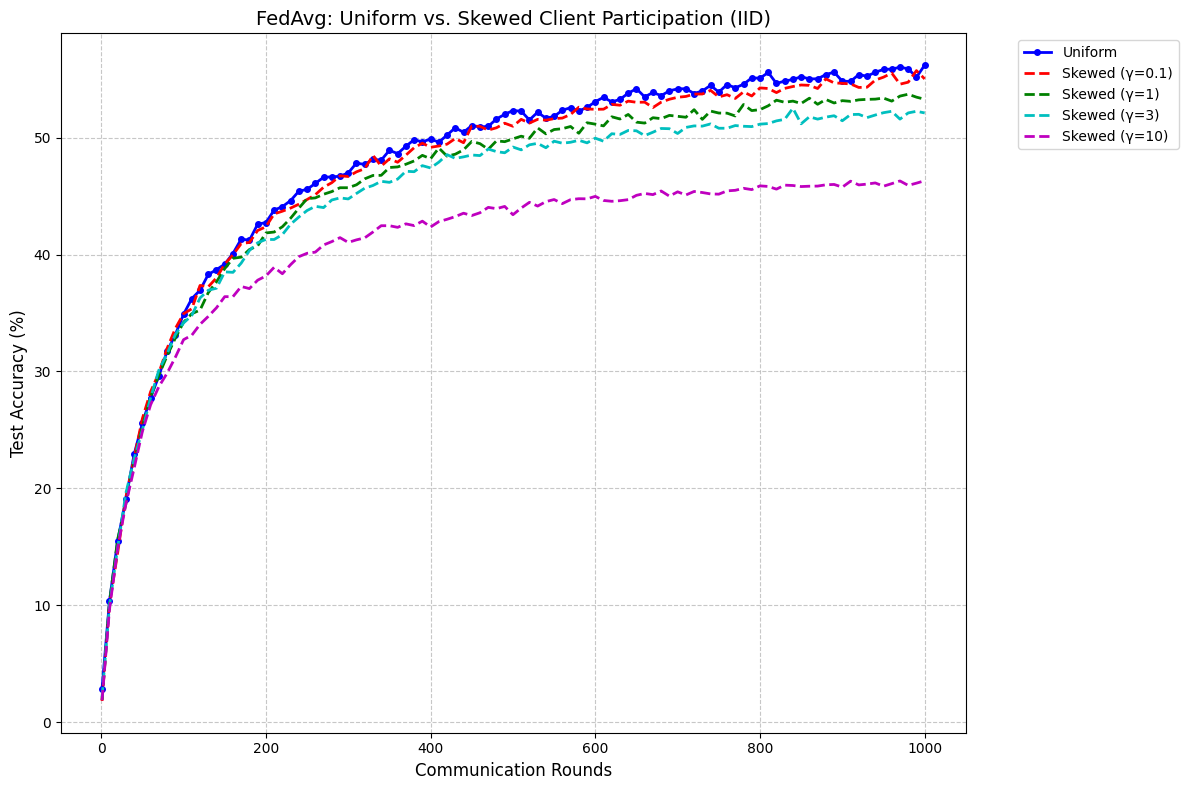


Final Test Accuracies:
Uniform: 56.21%
Skewed (γ=0.1): 55.03%
Skewed (γ=1): 53.29%
Skewed (γ=3): 52.12%
Skewed (γ=10): 46.32%

Experiments completed at 2025-01-21 074422


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import copy
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Import your pre-implemented classes
#from data_sharding import DatasetSharder, load_cifar100  # Assuming this is saved as data_sharding.py
#from client_selection import ClientSelector  # Assuming this is saved as client_selection.py

# =====================
# Parameters
# =====================

K = 100              # Total number of clients
C = 0.1              # Fraction of clients selected each round
N = 1000              # Total number of communication rounds
J = 4                # Number of local epochs
lr = 0.01             # Learning rate
B = 64               # Batch size for client training
test_freq = 10       # Frequency of evaluation on the test set

# Set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =====================
# Data Loading and Preprocessing
# =====================

# Load CIFAR-100 using your pre-implemented function
print("Loading CIFAR-100 dataset...")
trainset = load_cifar100()
testset = datasets.CIFAR100(root='./data', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5071, 0.4865, 0.4409),
                                                 (0.2673, 0.2564, 0.2761))
                           ]))

# Create test data loader
test_loader = DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)

# =====================
# Model Definition
# =====================

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# =====================
# Federated Learning Implementation
# =====================

class FedAvg:
    def __init__(self, config, model, client_datasets, test_loader, selector):
        self.config = config
        self.global_model = model
        self.client_datasets = client_datasets
        self.test_loader = test_loader
        self.device = device
        self.global_model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.selector = selector

    def client_update(self, client_model, optimizer, train_loader):
        client_model.train()
        for _ in range(self.config['local_epochs']):
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = client_model(data)
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()
        return client_model.state_dict()

    def aggregate(self, client_weights):
        global_weights = copy.deepcopy(client_weights[0])
        for key in global_weights.keys():
            for i in range(1, len(client_weights)):
                global_weights[key] += client_weights[i][key]
            global_weights[key] = torch.div(global_weights[key], len(client_weights))
        return global_weights

    def test(self):
        self.global_model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.global_model(data)
                loss = self.criterion(outputs, target)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        avg_loss = test_loss / len(self.test_loader)
        return accuracy, avg_loss

    def run(self):
        test_accuracies = []
        rounds_list = []

        for round_ in tqdm(range(self.config['rounds']), desc="Training"):
            selected_clients = self.selector.select()
            client_weights = []

            for client_idx in selected_clients:
                local_model = copy.deepcopy(self.global_model)
                local_model.to(self.device)
                optimizer = optim.SGD(
                    local_model.parameters(),
                    lr=self.config['lr'],
                    momentum=0.9,
                    weight_decay=0.0004
                )

                train_loader = DataLoader(
                    self.client_datasets[client_idx],
                    batch_size=self.config['batch_size'],
                    shuffle=True
                )

                weights = self.client_update(local_model, optimizer, train_loader)
                client_weights.append(weights)

            global_weights = self.aggregate(client_weights)
            self.global_model.load_state_dict(global_weights)

            if (round_ + 1) % self.config['test_freq'] == 0 or round_ == 0:
                accuracy, loss = self.test()
                test_accuracies.append(accuracy)
                rounds_list.append(round_ + 1)
                print(f"\nRound {round_+1}: Accuracy = {accuracy:.2f}%, Loss = {loss:.4f}")

        return test_accuracies, rounds_list

# =====================
# Main Execution
# =====================

if __name__ == "__main__":
    print(f"Starting experiments at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Create IID sharded datasets
    data_config = {'K': K, 'shard_type': 'iid'}
    sharder = DatasetSharder(data_config, trainset)
    client_datasets = sharder.shard_dataset()

    # Base configuration for all experiments
    base_config = {
        'rounds': N,
        'local_epochs': J,
        'lr': lr,
        'batch_size': B,
        'test_freq': test_freq
    }

    # Store results
    results = {}

    # Run uniform participation
    config_uniform = {
        'K': K,
        'C': C,
        'participation': 'uniform'
    }
    selector_uniform = ClientSelector(config_uniform)
    model = EnhancedLeNet()
    fedavg = FedAvg(base_config, model, client_datasets, test_loader, selector_uniform)
    print("\nRunning Uniform Participation...")
    uniform_accuracies, uniform_rounds = fedavg.run()
    results['Uniform'] = (uniform_rounds, uniform_accuracies)

    # Run skewed participation with different gamma values
    gamma_values = [0.1, 1, 3, 10]
    for gamma in gamma_values:
        config_skewed = {
            'K': K,
            'C': C,
            'participation': 'skewed',
            'gamma': gamma
        }
        selector_skewed = ClientSelector(config_skewed)
        model = EnhancedLeNet()
        fedavg = FedAvg(base_config, model, client_datasets, test_loader, selector_skewed)
        print(f"\nRunning Skewed Participation (γ={gamma})...")
        skewed_accuracies, skewed_rounds = fedavg.run()
        results[f'Skewed (γ={gamma})'] = (skewed_rounds, skewed_accuracies)

    # Plot results
    plt.figure(figsize=(12, 8))
    colors = ['b', 'r', 'g', 'c', 'm']

    for (label, (rounds, accuracies)), color in zip(results.items(), colors):
        if label == 'Uniform':
            plt.plot(rounds, accuracies, f'{color}o-',
                    label=label, linewidth=2, markersize=4)
        else:
            plt.plot(rounds, accuracies, f'{color}--',
                    label=label, linewidth=2)

    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('FedAvg: Uniform vs. Skewed Client Participation (IID)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save plot
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'fedavg_participation_comparison_{timestamp}.png',
                bbox_inches='tight', dpi=300)
    plt.show()

    # Print final accuracies
    print("\nFinal Test Accuracies:")
    for label, (rounds, accuracies) in results.items():
        print(f"{label}: {accuracies[-1]:.2f}%")

    print(f"\nExperiments completed at {datetime.now().strftime('%Y-%m-%d %H%M%S')}")